# Coherent Single Qubit Annealing

## Spin-level annealing

A flux qubit can be approximated by a single spin Hamiltonian in small range of external fluxes. In an annealing context, the spin level Hamiltonian can be described:

$$\hat{H}(s)=A(s)\hat{\sigma}_x+B(s)\hat{\sigma}_z$$

where

$$s = \frac{t}{t_\mathrm{an}}$$

is the normalised annealing time and $A(s)$ and $B(s)$ are the energy annealing schedules. Colleagues at USC have shown that it may be possible to reveal coherence effects using this system by measuring the ground state population as a function of annealing time $t_\mathrm{an}$.

Analysis of CSQA is performed in `qutip`, which implements a numerical solver of the Lindblad equation. When coherence is assumed infinite, the equation reduces to the Liouville-von-Neumann equation. Decoherence can be introduced by specifying Lindblad operators. The effect of thermal fluctuations can be introduced by specifying the initial state in thermal equilibrium using the KMS state.

Some useful links:
* [Qutip documentation](http://qutip.org/docs/4.1/apidoc/apidoc.html)
* [von-Neumann equation](https://en.wikipedia.org/wiki/Density_matrix#The_von_Neumann_equation_for_time_evolution)
* [KMS state](https://en.wikipedia.org/wiki/KMS_state)

### Linear Schedules

Evidence of ground state probability oscillations are seen when using linear energy schedules such that an annealing operation is performed, i.e. that the system is initialised in a superposition state and driven towards a classical state. The schedules here are then:

$$ A(s) = \frac{1}{2}\left(1 - s\right)\Delta$$

where $\Delta$ is the nominal tunnel splitting.

$$ B(s) = \frac{s}{2}\varepsilon $$

where $\varepsilon$ is the double well tilt splitting. $s$ runs from 0 to 1 in a conventional anneal. The functions for these schedules can be implemented such that there is defined behaviour outside of this range too.

In [61]:
import numpy as np
import qutip as qt
import scipy as sc
import scipy.signal as scs
import physical_constants as pc
import matplotlib as mpl
import matplotlib.colors as cl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
mpl.rcParams.update({'font.size':20}) # This sometimes needs to be run twice to make it work

# Progress bar yay
from ipywidgets import FloatProgress

In [5]:
# Annealing schedules
# X
def Alin(t,p):
    if type(t) in [np.ndarray,list]:
        ret = []
        for ti in t:
            if ti < 0.0:
                ret.append(p["delta"])
            elif ti >= 0.0 and ti <= p["tan"]:
                ret.append(p["delta"]*(1.0-ti/p["tan"]))
            else:
                ret.append(0.0)
        return np.array(ret)
    else:
        if t < 0.0:
            return p["delta"]
        elif t >= 0.0 and t <= p["tan"]:
            return p["delta"]*(1.0-t/p["tan"])
        else:
            return 0.0

# Z
def Blin(t,p):
    if type(t) in [np.ndarray,list]:
        ret = []
        for ti in t:
            if ti < 0.0:
                ret.append(0.0)
            elif ti >= 0.0 and ti <= p["tan"]:
                ret.append(p["epsilon"]*ti/p["tan"])
            else:
                ret.append(p["epsilon"])
        return np.array(ret)
    else:
        if t < 0.0:
            return 0.0
        elif t >= 0.0 and t <= p["tan"]:
            return p["epsilon"]*t/p["tan"]
        else:
            return p["epsilon"]


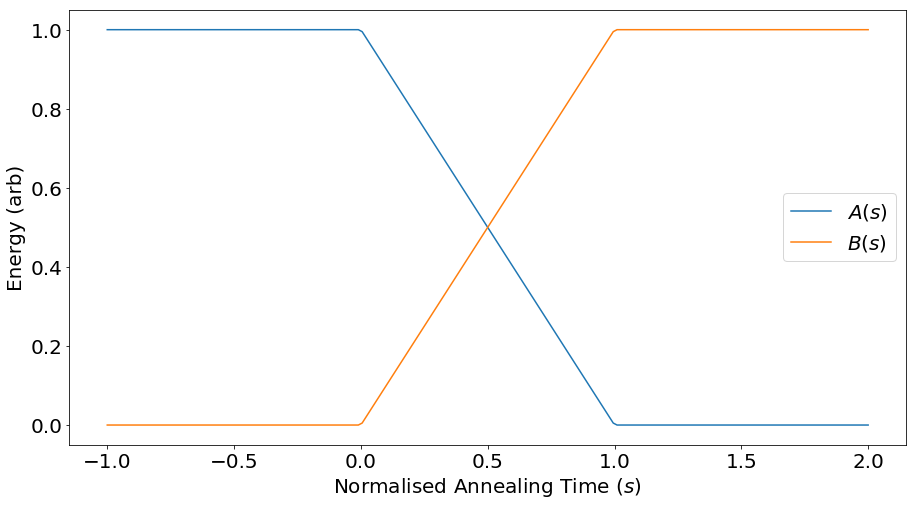

In [6]:
# Range of s
s = np.linspace(-1,2,201)

# Schedule parameters
p={"tan":1,"epsilon":1,"delta":1}

# Plot annealing schedules
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(s, Alin(s,p), label="$A(s)$")
ax.plot(s, Blin(s,p), label="$B(s)$")
ax.set_xlabel('Normalised Annealing Time ($s$)')
ax.set_ylabel('Energy (arb)')
ax.legend()

### Solving Time-Dependence

In `qutip`, the von-Neumann equation is solved when infinite coherence is assumed. This equation uses the density matrix formalism:

$$\mathrm{i}\hbar \frac{\partial \hat{\rho}}{\partial t} = \left[ \hat{H}, \hat{\rho} \right]$$

which is very difficult to solve analytically when the Hamiltonian is time-dependent. In all annealing cases we will do this numerically. The result of solving this is a density matrix at each selected time, so to extract the ground state probability at time $t_i$ one does

$$p_g(t_i) = \langle g | \hat{\rho}(t_i) | g \rangle$$

where $|g\rangle$ is the ground eigenstate of the final Hamiltonian, i.e. $B(1)\hat{\sigma}_z$ in this case. The function `mesolve` actually returns the total state vector, which can be converted to a density matrix using the `ket2dm` function which does

$$\hat{\rho}(t_i) = | \psi(t_i)\rangle \langle \psi(t_i) |$$

We can also look at the expectation values of each spin operator, which can be used to plot the time evolution of the state vector on the Bloch sphere.

First let's look at that to get a visual representation of what is going on during an anneal, so as a function of $s$:

In [7]:
# Maximum X tunneling and Z bias terms in GHz (angular frequency)
hx=0.25*2*np.pi
hz=0.25*2*np.pi

# Hamiltonian at t=0
tan = 2 # 2 ns
p={"tan":tan,"epsilon":hz,"delta":hx}
H0 = Alin(0,p)*qt.sigmax() + Blin(0,p)*qt.sigmaz()

# Get the ground state at t=0 with eigenvalue E0,
# used as initial state in dynamics simulation
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# Single half spin annealing Hamiltonian
# Using qutips functional time dependence array structure
# A(t)sigma_x + B(t)sigma_z
H = [[qt.sigmax(),Alin],[qt.sigmaz(),Blin]]

# Use time dependent Hamiltonian and specify initial state
# Unitary evolution: No dissipation
times = np.linspace(-tan,2*tan,100)
result = qt.mesolve(
    H,
    psi0,
    times,
    [],
    [qt.sigmaz(),qt.sigmay(),qt.sigmax()], # Here we tell qutip to evaluate the expectation value of these operators
    args=p,
    options=qt.Options(nsteps=10000) # Sometimes required to ensure convergence
)

# Save relevant results
pop0_zt = result.expect[0]
pop0_yt = result.expect[1]
pop0_xt = result.expect[2]

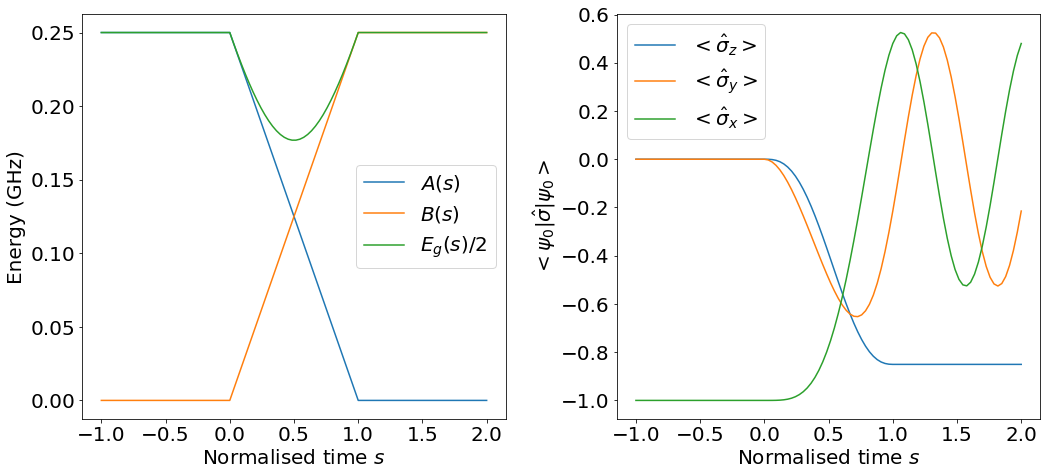

In [8]:
# Plot annealing schedule and oscillations of the expectation values
fig = plt.figure(figsize=(15,7))

# Schedules
xpts = np.linspace(-1*tan,2*tan,100)
ax1 = plt.subplot(121)
ax1.plot(xpts/tan,Alin(xpts,p)/(2*np.pi))
ax1.plot(xpts/tan,Blin(xpts,p)/(2*np.pi))
ax1.plot(xpts/tan,np.sqrt(Alin(xpts,p)**2+Blin(xpts,p)**2)/(2*np.pi))
ax1.set_xlabel('Normalised time $s$')
ax1.set_ylabel('Energy (GHz)')
ax1.legend(("$A(s)$","$B(s)$","$E_g(s)/2$"))

# Oscillations
ax2 = plt.subplot(122)
ax2.plot(times/tan, pop0_zt)
ax2.plot(times/tan, pop0_yt)
ax2.plot(times/tan, pop0_xt)
ax2.set_xlabel('Normalised time $s$')
ax2.set_ylabel('$<\psi_0|\hat{\sigma}|\psi_0>$')
ax2.legend(["$<\hat{\sigma}_z>$","$<\hat{\sigma}_y>$","$<\hat{\sigma}_x>$"])

fig.tight_layout()

We see above that the $\hat{\sigma}_z$ expectation value doesn't reach it's maximum value, which is expected since the anneal here is done so fast (2 ns). So this is anneal done non-adiabatically. We can see what this looks like on a Bloch sphere.

Below, the left Bloch sphere shows in the solid blue the state vector trajectory during the whole time specified, in green the initial state vector is shown. In orange the projection of the state vector onto the Z axis at the end of the anneal is shown, which corresponds to the expectation value of the $\hat{\sigma}_z$ operator at that time.

The right Bloch sphere plots the actual state vectors. Since the evolution is unitary, all the vectors have modulus 1.

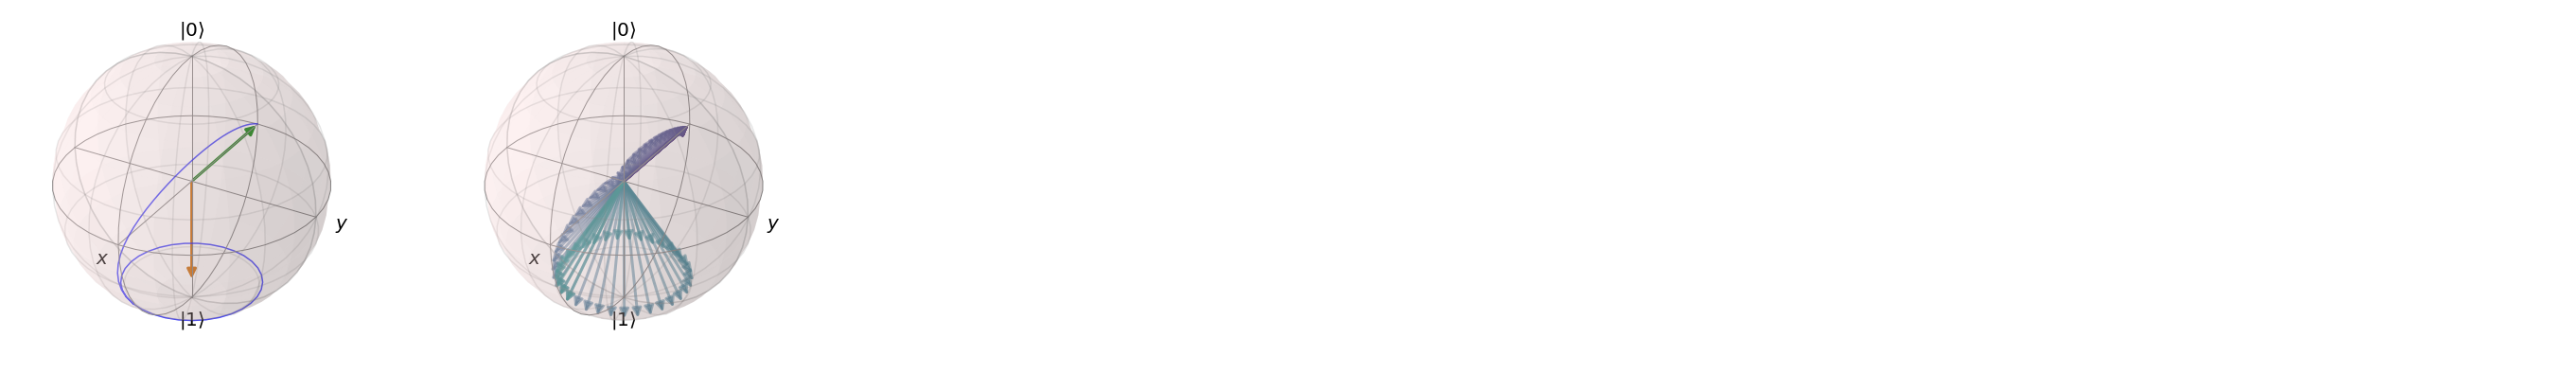

In [9]:
# Plot points and state vectors
fig = plt.figure(figsize=(15,7))
ax1 = plt.subplot(121,projection="3d")
ax2 = plt.subplot(122,projection="3d")

# Gen points from eigenvalues
sv_pts = [pop0_xt,pop0_yt,pop0_zt]
b1 = qt.Bloch(fig=fig,axes=ax1)
b1.add_points(sv_pts,meth='l')
b1.add_vectors([pop0_xt[0],pop0_yt[0],pop0_zt[0]]) # add the state vector at t=0
b1.add_vectors([0,0,pop0_zt[-1]]) # add the projection of the state vector onto the sigmaz ground state at t=tan
b1.render(fig=fig,axes=ax1)

colors = cm.viridis(np.linspace(0, 1, 200))
cls = []
for c in colors:
    c[3] = 0.5
    cls.append(cl.to_hex(c,True))

#print (cls)
# Gen vectors from eigenvalues
sv_vecs = [[pop0_xt[i],pop0_yt[i],pop0_zt[i]] for i in range(100)]
b2 = qt.Bloch(fig=fig,axes=ax2)
b2.vector_color = cls
b2.add_vectors(sv_vecs)
b2.render(fig=fig,axes=ax2)


Ok now let's look at the probability of finding the ground state as a function of annealing time. In this case the Hamiltonian is different for each $t_\mathrm{an}$, a loop is needed to change this, in which the time dependence for each case is solved. The good thing is we only need density matrix at the end of the anneal:

In [10]:
# Maximum X tunneling and Z bias terms in GHz (angular frequency)
hx=0.25*2*np.pi
hz=0.25*2*np.pi

# Range of annealing times
tf_min = 0.0
tf_max = 15.0
tf = np.linspace(tf_min,tf_max,201)

# Hamiltonian at t=0
tan = 2 # 2 ns
p={"tan":tan,"epsilon":hz,"delta":hx}
H0 = Alin(0,p)*qt.sigmax() + Blin(0,p)*qt.sigmaz()

# Get the ground state at t=0 with eigenvalue E0,
# used as initial state in dynamics simulation
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# Single half spin annealing Hamiltonian
# Using qutips functional time dependence array structure
# A(t)sigma_x + B(t)sigma_z
H = [[qt.sigmax(),Alin],[qt.sigmaz(),Blin]]

# Express results in terms of the Z spin operator states
E,states=qt.sigmaz().eigenstates()

# Use the Lindblad master equation solver
p0 = np.zeros(len(tf))
for i,tan in enumerate(tf):
    times = np.array([0,tan]) # Solve for final time only, initial time must be specified too
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    p={"tan":tan,"epsilon":hz,"delta":hx}
    result = qt.mesolve(H, psi0, times, [], [], args=p, options=qt.Options(nsteps=10000))
    
    # Save relevant results
    p0[i] = qt.expect(qt.ket2dm(result.states[-1]),states[0])

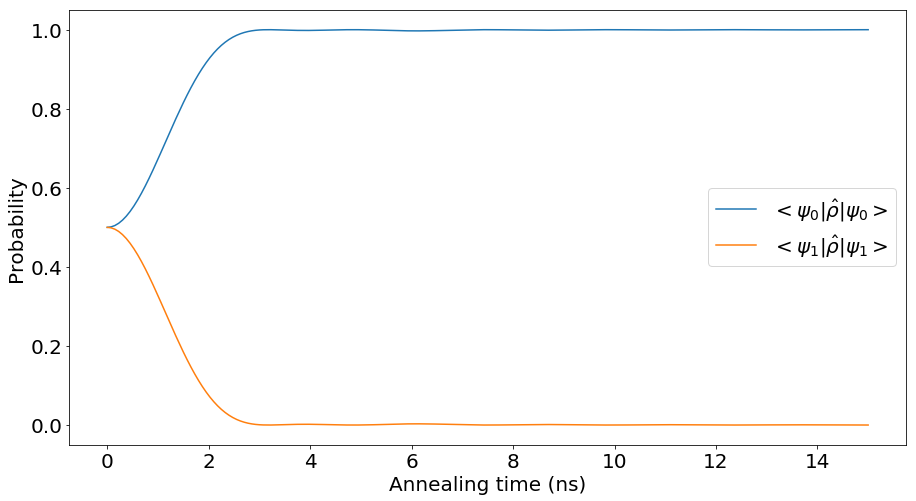

In [11]:
# Plot probabilities
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tf, p0, label="$<\psi_0|\hat{\\rho}|\psi_0>$")
ax.plot(tf, 1-p0, label="$<\psi_1|\hat{\\rho}|\psi_1>$")
#ax.plot(tf, B(s,p), label="$B(s)$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend()

In this plot one can see small oscillations, but we do not expect to be able to measure these experimentally at all. Also we are not sure if this really is a 'coherent' effect, since there is only one Landau-Zener point created by these schedules, at $E_g(s=0.5)$, and thus no obvious interference effect.

### Non-linear Schedules

Now we will look at non-linear schedules that show much more obvious oscillations, it will be left as an exercise to calculate the expectation values/oscillations and compare with the linear schedules.

Colleagues at USC first used the following schedules to reveal large oscillations:

$$A(s)=\frac{1}{2} \Delta (1-s^{2n})$$

and

$$B(s)=\frac{1}{2} \varepsilon s^{1/n}$$

where $n=4$ was used. This is an example of a schedule that would be implemented experimentally using an AWG.

In [12]:
# Annealing schedules
# X
def Ausc1(t,p):
    if type(t) in [np.ndarray,list]:
        ret = []
        for ti in t:
            if ti < 0.0:
                ret.append(p["delta"])
            elif ti >= 0.0 and ti <= p["tan"]:
                ret.append(p["delta"]*(1.0-(ti/p["tan"])**(2*p["n"])))
            else:
                ret.append(0.0)
        return np.array(ret)
    else:
        if t < 0.0:
            return p["delta"]
        elif t >= 0.0 and t <= p["tan"]:
            return p["delta"]*(1.0-(t/p["tan"])**(2*p["n"]))
        else:
            return 0.0

# Z
def Busc1(t,p):
    if type(t) in [np.ndarray,list]:
        ret = []
        for ti in t:
            if ti < 0.0:
                ret.append(0.0)
            elif ti >= 0.0 and ti <= p["tan"]:
                ret.append(p["epsilon"]*(ti/p["tan"])**(1/p["n"]))
            else:
                ret.append(p["epsilon"])
        return np.array(ret)
    else:
        if t < 0.0:
            return 0.0
        elif t >= 0.0 and t <= p["tan"]:
            return p["epsilon"]*(t/p["tan"])**(1/p["n"])
        else:
            return p["epsilon"]

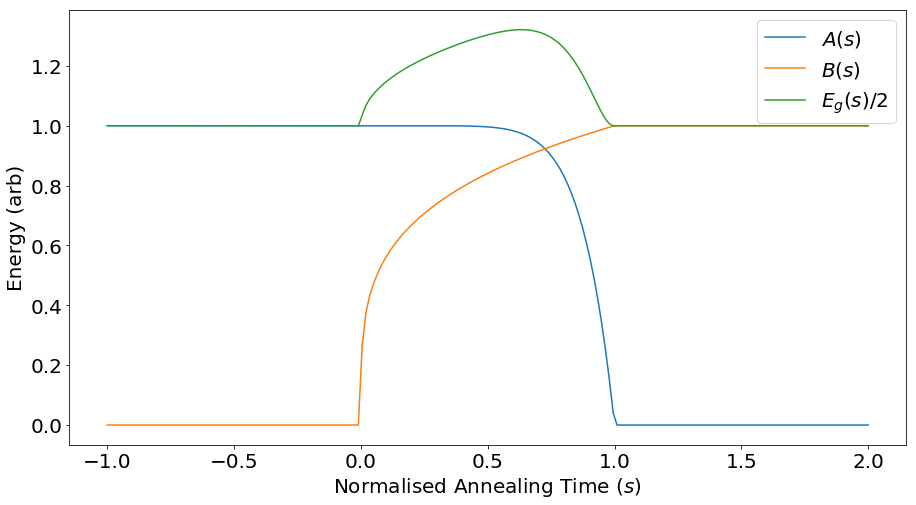

In [13]:
# Range of s
s = np.linspace(-1,2,201)

# Schedule parameters
p={"tan":1,"epsilon":1,"delta":1,"n":4}

# Plot annealing schedules
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(s, Ausc1(s,p), label="$A(s)$")
ax.plot(s, Busc1(s,p), label="$B(s)$")
ax.plot(s, np.sqrt(Ausc1(s,p)**2 + Busc1(s,p)**2), label="$E_g(s)/2$")
ax.set_xlabel('Normalised Annealing Time ($s$)')
ax.set_ylabel('Energy (arb)')
ax.legend()

In [14]:
# Maximum X tunneling and Z bias terms in GHz (angular frequency)
hx=0.25*2*np.pi
hz=0.25*2*np.pi

# Range of annealing times
tf_min = 0.0
tf_max = 15.0
tf = np.linspace(tf_min,tf_max,201)

# Hamiltonian at t=0
tan = 2 # 2 ns
p={"tan":tan,"epsilon":hz,"delta":hx,"n":4}
H0 = Ausc1(0,p)*qt.sigmax() + Busc1(0,p)*qt.sigmaz()

# Get the ground state at t=0 with eigenvalue E0,
# used as initial state in dynamics simulation
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# Single half spin annealing Hamiltonian
# Using qutips functional time dependence array structure
# A(t)sigma_x + B(t)sigma_z
H = [[qt.sigmax(),Ausc1],[qt.sigmaz(),Busc1]]

# Express results in terms of the Z spin operator states
E,states=qt.sigmaz().eigenstates()

# Use the Lindblad master equation solver
p01 = np.zeros(len(tf))
p02 = np.zeros(len(tf))
p03 = np.zeros(len(tf))
for i,tan in enumerate(tf):
    times = np.array([0,tan]) # Solve for final time only, initial time must be specified too
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    p={"tan":tan,"epsilon":hz,"delta":hx,"n":4}
    result1 = qt.mesolve(H, psi0, times, [], [], args=p, options=qt.Options(nsteps=10000))
    result2 = qt.mesolve(H, psi0, times, [np.sqrt(0.05)*qt.sigmax()], [], args=p, options=qt.Options(nsteps=10000))
    result3 = qt.mesolve(H, psi0, times, [np.sqrt(0.05)*qt.sigmaz()], [], args=p, options=qt.Options(nsteps=10000))
    
    # Save relevant results
    p01[i] = qt.expect(qt.ket2dm(result1.states[-1]),states[0])
    p02[i] = qt.expect(result2.states[-1],states[0])
    p03[i] = qt.expect(result3.states[-1],states[0])

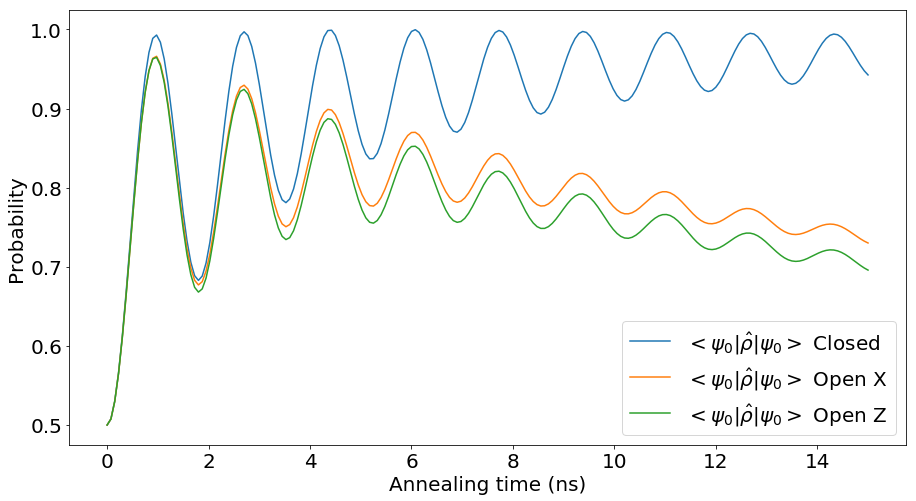

In [15]:
# Plot probabilities
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.plot(tf, p01, label="$<\psi_0|\hat{\\rho}|\psi_0>$ Closed")
ax.plot(tf, p02, label="$<\psi_0|\hat{\\rho}|\psi_0>$ Open X")
ax.plot(tf, p03, label="$<\psi_0|\hat{\\rho}|\psi_0>$ Open Z")
#ax.plot(tf, B(s,p), label="$B(s)$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend()

## Circuit Hamiltonian and Annealing

To introduce the analogue schedules proposed here, it is necessary to introduce a simple circuit Hamiltonian, since its inherent non-linear response to external flux schedules is exploited to form energy schedules that lead to large oscillations.

### Tunable CSFQ with negligible inductance

The tunable capacitively shunted flux qubit (CSFQ) is a four Josephson junction flux qubit where two junction with areas smaller by a factor $\alpha$ form a DC-SQUID. When assuming that the geometrical inductance of the loops is negligible, and neglecting fast degrees of freedom (Born-Oppenheimer approximation), the Hamiltonian for this system can be expressed in the charge basis as

$$\hat{H} = \frac{1}{2}E_\mathrm{C} \hat{n}^2 -2E_\mathrm{J}\cos\left(\hat{\phi}\right) +\alpha E_\mathrm{J}\cos\left(\frac{\phi_x}{2}\right)\cos\left(2\hat{\phi} + \phi_z\right)$$

where $E_\mathrm{C}$ and $E_\mathrm{J}$ are the charging and Josephson energies respectively and $\phi_x$ and $\phi_z$ are the external phases applied to the X and Z loops of the CSFQ respectively. $\hat{n}$ is Cooper pair number operator and $\hat{\phi}$ is the phase operator.

In the charge basis the operators can be expressed as

$$\hat{n} = \hat{a}\hat{a}^\dagger$$

where $\hat{a}$ is the creation operator.

The phase operators can be expressed as

$$\cos\left(\hat{\phi}+\phi_e\right) = \frac{1}{2}\left( e^{j\phi_e} \hat{D} + e^{-j\phi_e} \hat{D}^\dagger \right)$$

where $\hat{D}$ is the charge raising operator which has the property

$$\hat{D} |n\rangle = |n+1\rangle$$

The last term in the Hamiltonian is written as

$$\cos\left(2\hat{\phi}+\phi_e\right) = \frac{1}{2}\left( e^{j\phi_e} {\hat{D}}^2 + e^{-j\phi_e} {\hat{D}^{\dagger 2}} \right)$$

in terms of the defined operators. The charge raising operator can be defined in qutip by building the operator with the charge (Fock) states:

$$\hat{D} = \sum_{n=0}^{N-1}|n\rangle\langle n+1|$$

With these definitions it is possible to diagonalise the Hamiltonian and find the energy eigenvalues and eigenstates. Below we include functions for two versions of this Hamiltonian, one with the BO approximation and one without. The former is much faster and is good enough to use, but you may wish to use the other to compare results. Both of these codes also include the asymmetry parameter `asy` which modifies the Hamiltonian such that it can be written, under the same above approximations, as

$$\hat{H} = \frac{1}{2}E_\mathrm{C} \hat{n}^2 -2E_\mathrm{J}\cos\left(\hat{\phi}\right) +\alpha \sqrt{1 + d^2 \tan^2\left(\frac{\phi_x}{2}\right)} E_\mathrm{J}\cos\left(\frac{\phi_x}{2}\right)\cos\left(2\hat{\phi} + \phi_z - \phi_{z,o}\right)$$

where

$$d = \frac{E_{j1} - E_{j2}}{E_{j1} + E_{j2}}$$

is the asymmetry parameter (`asy` in the code) involving the Josephson energies of both junctions in the DC-SQUID loop. This creates an offset in the energy minimum, expected to be at half flux,

$$\phi_{z,o} = \arctan^{-1}\left(d \tan\left(\frac{\phi_x}{2}\right)\right)$$

The parameter $d$ can be on the order of $0.1$. I will leave it as an exercise to see what the effect of the asymmetry is.

For background reading on the CSFQ qubit, see
* Supplementary material Appendix E of [this paper](https://www.nature.com/articles/s41534-017-0037-z)
* [History of the CSFQ](https://arxiv.org/pdf/1508.06299.pdf)

In [16]:
#
#   CSFQ Hamiltonian with BO approximation and negligible inductance.
#
def Hcsfq_BO_nL(phi_x,phi_z,Jc,Ca,Ajj,alpha,Csh,asy=0.0,Q=None,Dp=None,Dm=None):

    # Asymmetry factor and phase
    asy_f = np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
    asy_p = np.arctan(asy * np.tan(phi_x/2))
    
    # Total capacitance (F)
    Csigma = (0.5+alpha)*Ajj*Ca*1e-15 + Csh
    
    # Charging energy (GHz)
    Ec = 2*pc.e**2/(Csigma*pc.hbar) * 1e-9
    
    # Josephson energy (GHz)
    Ej = Ajj*Jc*pc.phi0/(2*np.pi*pc.hbar) * 1e-15
    
    # Construct Hamiltonian
    H = 0.5*Ec*Q**2 - Ej*(Dp+Dm) + asy_f*0.5*alpha*Ej*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*Dp**2+np.exp(-1j*(phi_z-asy_p))*Dm**2)
    
    # Return relevant parts
    return H.data.todense()

#
#   CSFQ Hamiltonian without BO approximation and negligible inductance.
#
def Hcsfq_nL(phi_x,phi_z,Jc,Ca,Ajj,alpha,Csh,asy=0.0,Qms=None,Qps=None,Dt=None,Dms=None,Dps=None):

    # Asymmetry factor and phase
    asy_f = np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
    asy_p = np.arctan(asy * np.tan(phi_x/2))
    
    # Slow charging energy (GHz)
    Em = 2*pc.e**2/((2*Csh + (2*alpha+1)*Ajj*Ca*1e-15)*pc.hbar) * 1e-9
    
    # Fast charging energy (GHz)
    Ep = 2*pc.e**2/(Ajj*Ca*1e-15*pc.hbar) * 1e-9
    
    # Josephson energy (GHz)
    Ej = Ajj*Jc*pc.phi0/(2*np.pi*pc.hbar) * 1e-15
    
    # Construct Hamiltonian
    H = 0.5*Em*Qms + 0.5*Ep*Qps - 0.5*Ej*Dt + asy_f*0.5*alpha*Ej*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*Dps+np.exp(-1j*(phi_z-asy_p))*Dms)
    
    # Return relevant parts
    return H.data.todense()

In [17]:
# Define some reasonable parameters
Jc = 3 # uA/um^2
Ca = 60 # fF/um^2
Ajj = 0.31*0.15 # um^2
alpha = 1.0
Csh = 100e-15 # F
asy = 0.0

#
# Create the operators for BO CSFQ
#

# Hilbert space truncation for single DoF
trunc = 80

# Charge operator
Q = qt.num(trunc,-(trunc - 1)/2)

# Charge raising operator
Dp = qt.qeye(trunc) - qt.qeye(trunc)
for i in range(trunc-1):
    Dp += qt.basis(trunc,i)*qt.basis(trunc,i+1).dag()

# Charge lowering operator
Dm = Dp.dag()

#
# Create the operators for non-BO CSFQ
#

# Two Hilbert space truncators
truncm = 80
truncp = 20

# Charge operators
Qm = qt.num(truncm,-(truncm - 1)/2)
Qp = qt.num(truncp,-(truncp - 1)/2)

# Slow charge raising operator
Dm_p = qt.qeye(truncm) - qt.qeye(truncm)
for i in range(truncm-1):
    Dm_p += qt.basis(truncm,i)*qt.basis(truncm,i+1).dag()

# Slow charge lowering operator
Dm_m = Dm_p.dag()

# Fast charge raising operator
Dp_p = qt.qeye(truncp) - qt.qeye(truncp)
for i in range(truncp-1):
    Dp_p += qt.basis(truncp,i)*qt.basis(truncp,i+1).dag()

# Fast charge lowering operator
Dp_m = Dp_p.dag()

# Construct the operators in the extended Hilbert space
Qms = qt.tensor(Qm**2,qt.qeye(truncp))
Qps = qt.tensor(qt.qeye(truncm),Qp**2)
Dt = qt.tensor(Dm_p,Dp_p) + qt.tensor(Dm_m,Dp_m) + qt.tensor(Dm_m,Dp_p) + qt.tensor(Dm_p,Dp_m)
Dms = qt.tensor(Dm_m**2,qt.qeye(truncp))
Dps = qt.tensor(Dm_p**2,qt.qeye(truncp))

phiz = np.linspace(-0.2*np.pi,0.2*np.pi,201)
phix = np.linspace(-2*np.pi,2*np.pi,201)

In [298]:
# !!!!! THIS CELL TAKES A WHILE DUE TO NON-BO HAMILTONIAN, DONT RERUN UNLESS YOU CHANGE PARAMETERS !!!!!

# Gen data sets: BO
phiz = np.linspace(-0.2*np.pi,0.2*np.pi,201)
phix = np.linspace(-2*np.pi,2*np.pi,201)
Ex1 = [0.0]*201
Ez1 = [0.0]*201
for i,z in enumerate(phiz): # Sweep against Z flux
    E = np.linalg.eigvalsh(Hcsfq_BO_nL(0.0,z,Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm))
    Ez1[i] = E-E[0]
for i,x in enumerate(phix): # Sweep against X flux
    E = np.linalg.eigvalsh(Hcsfq_BO_nL(x,0.0,Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm))
    Ex1[i] = E-E[0]
Ez1 = np.array(Ez1)
Ex1 = np.array(Ex1)

# Gen data sets: non-BO
phiz = np.linspace(-0.2*np.pi,0.2*np.pi,201)
phix = np.linspace(-2*np.pi,2*np.pi,201)
Ex2 = [0.0]*201
Ez2 = [0.0]*201
for i,z in enumerate(phiz):
    E = np.linalg.eigvalsh(Hcsfq_nL(0.0,z,Jc,Ca,Ajj,alpha,Csh,asy=asy,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    Ez2[i] = E-E[0]
for i,x in enumerate(phix):
    E = np.linalg.eigvalsh(Hcsfq_nL(x,0.0,Jc,Ca,Ajj,alpha,Csh,asy=asy,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    Ex2[i] = E-E[0]
Ez2 = np.array(Ez2)
Ex2 = np.array(Ex2)

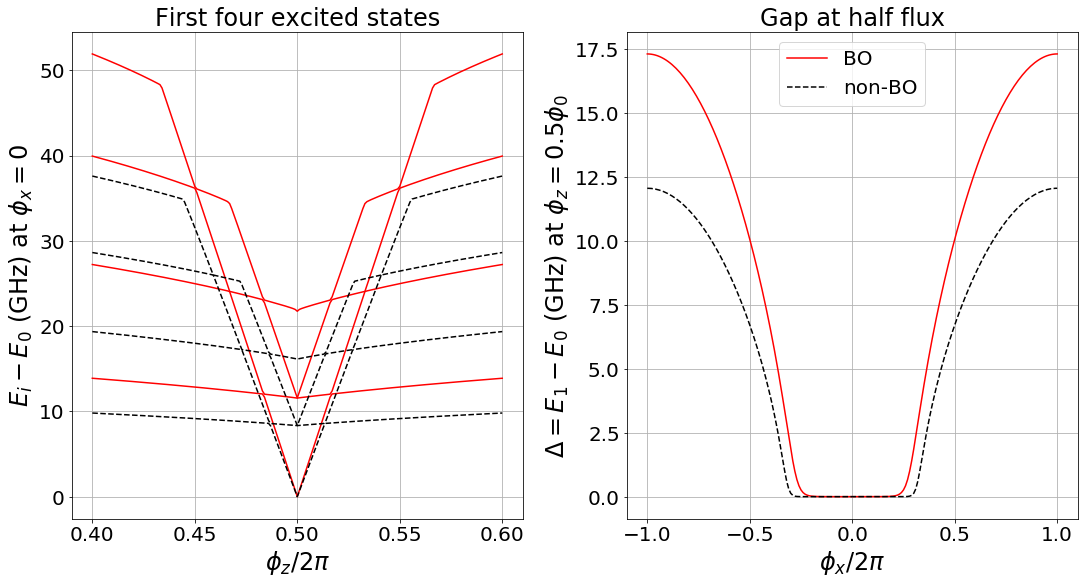

In [299]:
# Get figure and axis object
fig, ax = plt.subplots(1,2,constrained_layout=True,figsize=(15,8)) # WARNING! Experimental Feature that may break in the future
ax1 = ax[0]
ax2 = ax[1]

# Z dependence
for i in range(4):
    ax1.plot(phiz/(np.pi*2)+0.5, Ez1[:,i+1]/(2*np.pi),"r-")
    ax1.plot(phiz/(np.pi*2)+0.5, Ez2[:,2*i+2]/(2*np.pi),"k--")
ax1.set_xlabel('$\phi_z/2\pi$',fontsize="large")
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$',fontsize="large")
ax1.grid()
ax1.set_title("First four excited states")

# X dependence
ax2.plot(phix/(np.pi*2), Ex1[:,1]/(2*np.pi),"r-",label="BO")
ax2.plot(phix/(np.pi*2), Ex2[:,2]/(2*np.pi),"k--",label="non-BO")
ax2.set_xlabel('$\phi_x/2\pi$',fontsize="large")
ax2.set_ylabel('$\Delta = E_1-E_0$ (GHz) at $\phi_z = 0.5\phi_0$',fontsize="large")
ax2.grid()
ax2.set_title("Gap at half flux")
ax2.legend()

# Save
plt.show()
plt.close()

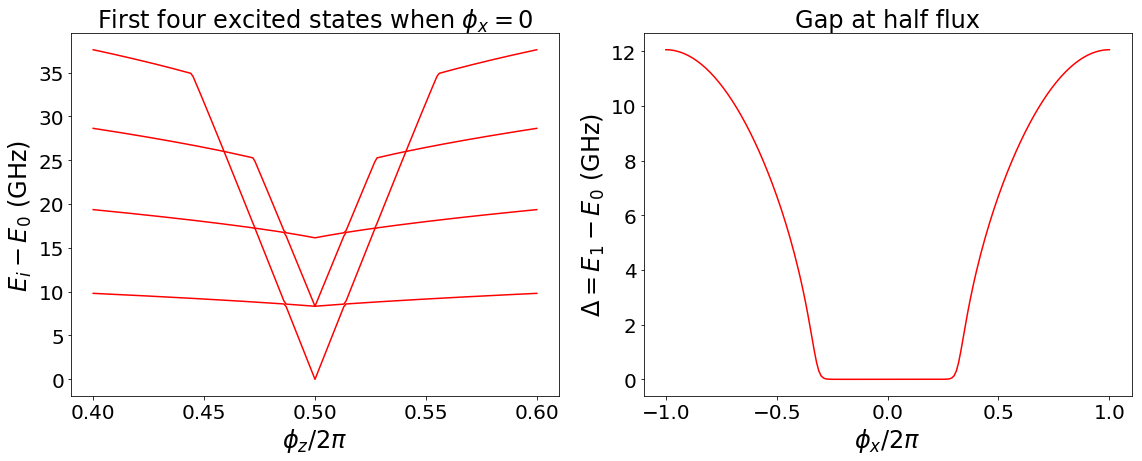

In [300]:
mpl.rcParams.update({'font.size':20})
# Get figure and axis object
fig, ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701)) # WARNING! Experimental Feature that may break in the future
ax1 = ax[0]
ax2 = ax[1]

# Z dependence
for i in range(4):
#    ax1.plot(phiz/(np.pi*2)+0.5, Ez1[:,i+1],"r-")
    ax1.plot(phiz/(np.pi*2)+0.5, Ez2[:,2*i+2]/(2*np.pi),"r-")
ax1.set_xlabel('$\phi_z/2\pi$',fontsize="large")
ax1.set_ylabel('$E_i-E_0$ (GHz)',fontsize="large")
#ax1.grid()
ax1.set_title("First four excited states when $\phi_x=0$")

# X dependence
#ax2.plot(phix/(np.pi*2), Ex1[:,1],"r-",label="BO")
ax2.plot(phix/(np.pi*2), Ex2[:,2]/(2*np.pi),"r-",label="non-BO")
ax2.set_xlabel('$\phi_x/2\pi$',fontsize="large")
ax2.set_ylabel('$\Delta = E_1-E_0$ (GHz)',fontsize="large")
#ax2.grid()
ax2.set_title("Gap at half flux")
#ax2.legend()

# Save
plt.savefig("CSFQ-spectrum-nonBO.png")
plt.show()
plt.close()

In the analogue schedule proposal, we are interested in using the nonlinearity in the dependence of the gap against X flux, which is shown in the right plot above. The gap at half flux effectively maps to $\Delta$, so we need a mapping technique to a two-level system to look at simple dynamics in this reduced state space.

### Using Perturbative Mapping:

This method is valid when $\phi_z \ll 1$, which is justified since we are only interested in the region close to $\phi_z = 0$ far from any avoided crossings with higher energy levels. From the plot above, $\phi_z$ should not exceed $0.05$ since the second excited state becomes significant.

Denoting the ground and first excited states as $|g\rangle$ and $|e\rangle$, the associated persistent current at degeneracy is

$$I_{p0} = \frac{4\pi E_\mathrm{J}}{\Phi_0} \left|\cos\left(\frac{\phi_x}{2}\right)\langle g|\sin\left(2\hat{\phi}\right) |e\rangle\right|$$

and the coefficients $\Delta$ and $\varepsilon$ can be extracted as

$$\Delta = E_e-E_g$$

and

$$\varepsilon = \frac{\Phi_0}{2\pi}\phi_z I_{p0}$$

It is then possible to introduce time dependence to $\phi_x$ and $\phi_z$ and describe the system in an Ising model with the derived coefficients above.

First we'll get the perturbative persistent current value as function of $\phi_x$:

Text(0, 0.5, '$I_{p0}$ (nA)')

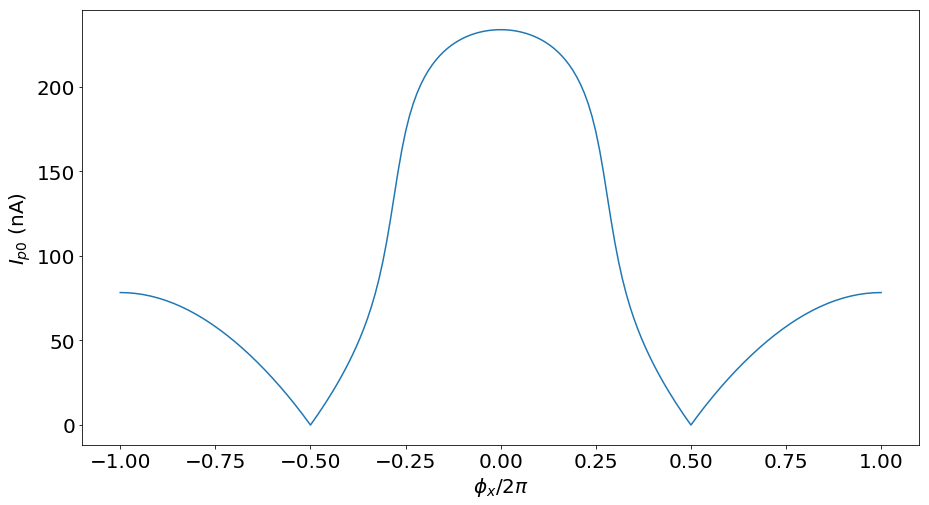

In [18]:
# Persistent current operator
def Ip_csfq(phi_x,ret_eig=False):
    
    # Get the first two state vectors from Hamiltonian diagonalised at phi_z = 0
    Ei,states = np.linalg.eigh(Hcsfq_BO_nL(phi_x,0.0,Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm))
    g = qt.Qobj(states[:,0])
    e = qt.Qobj(states[:,1])
    
    # Get the Josephson energy
    Ej = Jc*Ajj * 1e-6
    
    # Projection
    ex = (g.dag()*(Dm**2 - Dp**2)*e)[0][0]
    Ip = Ej*np.abs(np.cos(phi_x/2)*ex)[0]
    
    # Compute
    if ret_eig:
        return (Ip,Ei,states)
    else:
        return Ip

# Get Ip points
phi_x_pts = np.linspace(-2*np.pi,2*np.pi,201)
Ip0_pts = [Ip_csfq(phi_x) for phi_x in phi_x_pts]

# Plot the persistent current
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(phi_x_pts/(2*np.pi), np.array(Ip0_pts)*1e9)
ax.set_xlabel('$\phi_x/2\pi$')
ax.set_ylabel('$I_{p0}$ (nA)')

Now let's get the $\Delta$ and $\varepsilon$ coefficients as function of linear flux schedules, using a sensible range:

In [19]:
# Get the pauli coefficients
def AB_perturbative(phi_x,phi_z):
    
    # Get persistent current and states for phi_x value
    Ip,Ei,states = Ip_csfq(phi_x,ret_eig=True)
    
    # Compute coefficients
    delta = (Ei[1]-Ei[0])
    epsilon = pc.phi0*Ip*1e-9*phi_z/(2*np.pi*pc.hbar)
    return (delta,epsilon)

# Assume linear schedules
def phi_x_sig(t,p):
    if t < 0:
        return p["x_s"]
    elif t >= 0 and t <= p["tan"]:
        return p["x_s"]*(1.0-(t/p["tan"]))
    else:
        return 0.0

def phi_z_sig(t,p):
    if t < 0:
        return 0.0
    elif t >= 0 and t <= p["tan"]:
        return p["z_s"]*(t/p["tan"])
    else:
        return p["z_s"]

# Get phase points
tan = 10
p = {"tan":tan,"x_s":np.pi,"z_s":0.005*np.pi}
times = np.linspace(-tan,2*tan,200)
phi_x_p = np.array([phi_x_sig(t,p) for t in times])
phi_z_p = np.array([phi_z_sig(t,p) for t in times])

# Get energy points
delta_pts = []
eps_pts = []
for i in range(len(phi_x_p)):
    A,B = AB_perturbative(phi_x_p[i],phi_z_p[i])
    delta_pts.append(A)
    eps_pts.append(B)


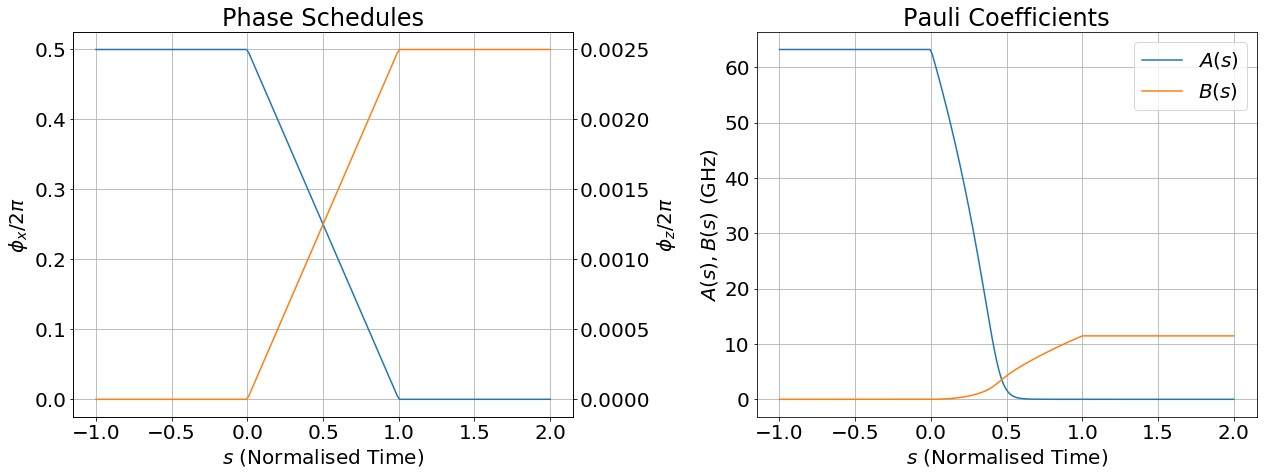

In [20]:
# Phase schedules
fig = plt.figure(figsize=(18,7))
ax11 = plt.subplot(121)
ax11.plot(times/tan, phi_x_p/(2*np.pi))
ax12 = ax11.twinx()
ax12.plot(times/tan, phi_z_p/(2*np.pi),'C1-')
ax11.set_title("Phase Schedules")
ax11.set_xlabel('$s$ (Normalised Time)')
ax11.set_ylabel('$\phi_{x}/2\pi$')
ax12.set_ylabel('$\phi_{z}/2\pi$')
#ax11.legend(("$\phi_x(s)$","$\phi_z(s)$"))
ax11.grid()

# Energy schedules
ax2 = plt.subplot(122)
ax2.plot(times/tan, delta_pts)
ax2.plot(times/tan, eps_pts)
ax2.set_title("Pauli Coefficients")
ax2.set_xlabel('$s$ (Normalised Time)')
ax2.set_ylabel('$A(s),B(s)$ (GHz)')
ax2.legend(["$A(s)$","$B(s)$"])
ax2.grid()
fig.tight_layout()

Ok so we see that we can't just put any flux signal in, we need to optimize that starting and finishing values of the flux schedules to match the energy scales that we need. We can do this by minimisation:

In [21]:
# Optimize in terms of start values
delta_max = np.pi
eps_max = np.pi

# Root finding methods
def AB_optimize_start(x):
    A,B = AB_perturbative(x[0],0)
    return [A-delta_max]
def AB_optimize_end(z):
    A,B = AB_perturbative(0,z[0])
    return [B-eps_max]

# Find the roots for A
ret = sc.optimize.root(AB_optimize_start,[0.9*np.pi])
if not ret.success:
    raise Exception("Not converged: %s" % ret.message)
print ("Solutions:")
print (ret.x)

phi_x_max = ret.x[0]

# Find the roots of A and B
ret = sc.optimize.root(AB_optimize_end,[0.005])
if not ret.success:
    raise Exception("Not converged: %s" % ret.message)
print ("Solutions:")
print (ret.x)

phi_z_max = ret.x[0]

Solutions:
[1.65546017]
Solutions:
[0.00430634]


In [22]:
# Get phase points
tan = 10
p = {"tan":tan,"x_s":phi_x_max,"z_s":phi_z_max}
times = np.linspace(-tan,2*tan,200)
phi_x_p = np.array([phi_x_sig(t,p) for t in times])
phi_z_p = np.array([phi_z_sig(t,p) for t in times])

print ("Start and End values of delta and epsilon:")
print (AB_perturbative(phi_x_p[0],phi_z_p[0]))
print (AB_perturbative(phi_x_p[-1],phi_z_p[-1]))

# Get energy points
Apts = []
Bpts = []
for i in range(len(phi_x_p)):
    A,B = AB_perturbative(phi_x_p[i],phi_z_p[i])
    Apts.append(A)
    Bpts.append(B)


Start and End values of delta and epsilon:
(3.1415926535894414, 0.0)
(0.001064343111920607, 3.141592653589793)


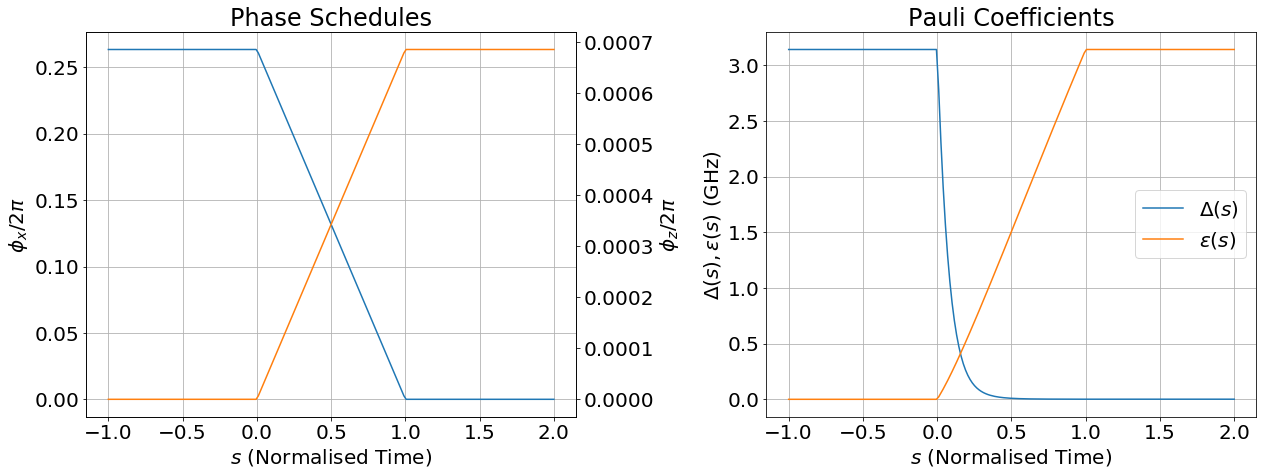

In [23]:
# Phase schedules
fig = plt.figure(figsize=(18,7))
ax11 = plt.subplot(121)
ax11.plot(times/tan, phi_x_p/(2*np.pi))
ax12 = ax11.twinx()
ax12.plot(times/tan, phi_z_p/(2*np.pi),'C1-')
ax11.set_title("Phase Schedules")
ax11.set_xlabel('$s$ (Normalised Time)')
ax11.set_ylabel('$\phi_{x}/2\pi$')
ax12.set_ylabel('$\phi_{z}/2\pi$')
#ax11.legend(("$\phi_x(s)$","$\phi_z(s)$"))
ax11.grid()

# Energy schedules
ax2 = plt.subplot(122)
ax2.plot(times/tan, Apts)
ax2.plot(times/tan, Bpts)
ax2.set_title("Pauli Coefficients")
ax2.set_xlabel('$s$ (Normalised Time)')
ax2.set_ylabel('$\\Delta(s),\\varepsilon(s)$ (GHz)')
ax2.legend(["$\\Delta(s)$","$\\varepsilon(s)$"])
ax2.grid()
fig.tight_layout()

Ok so now we've matched the energy scales, we can create controlled energy schedules. In particular, notice how the $\Delta(s)$ term is highly non-linear, we will exploit this in our analogue schedules.

To control this non-linearity to some extent, i.e. if we want the $A$ schedule not change so steaply in a short time, we use a different value of final flux. Since $\Delta$ depends on $\phi_z$, the values must be reoptimised.

In [24]:
# Target minimum X phase
phi_x_min = 0.25*np.pi

# Optimize in terms of start values
Amax = np.pi
Bmax = np.pi

# Root finding methods
def AB_optimize_start(x):
    A,B = AB_perturbative(x[0],0)
    return [A-delta_max]
def AB_optimize_end(z):
    A,B = AB_perturbative(phi_x_min,z[0])
    return [B-eps_max]

# Find the roots for A
ret = sc.optimize.root(AB_optimize_start,[0.9*np.pi])
if not ret.success:
    raise Exception("Not converged: %s" % ret.message)
print ("Solutions:")
print (ret.x)

phi_x_max = ret.x[0]

# Find the roots of A and B
ret = sc.optimize.root(AB_optimize_end,[0.005])
if not ret.success:
    raise Exception("Not converged: %s" % ret.message)
print ("Solutions:")
print (ret.x)

phi_z_max = ret.x[0]

Solutions:
[1.65546017]
Solutions:
[0.004469]


In [25]:
# Assume linear schedules
def phi_x_sig(t,p):
    if t < 0:
        return p["x_max"]
    elif t >= 0 and t <= p["tan"]:
        return (p["x_min"] - p["x_max"])*(t/p["tan"]) + p["x_max"]
    else:
        return p["x_min"]

def phi_z_sig(t,p):
    if t < 0:
        return 0.0
    elif t >= 0 and t <= p["tan"]:
        return p["z_max"]*(t/p["tan"])
    else:
        return p["z_max"]

# Get phase points
tan = 10
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
times = np.linspace(-tan,2*tan,200)
phi_x_p = np.array([phi_x_sig(t,p) for t in times])
phi_z_p = np.array([phi_z_sig(t,p) for t in times])

print ("Start and End values of delta and epsilon:")
print (AB_perturbative(phi_x_p[0],phi_z_p[0]))
print (AB_perturbative(phi_x_p[-1],phi_z_p[-1]))

# Get energy points
Apts = []
Bpts = []
for i in range(len(phi_x_p)):
    A,B = AB_perturbative(phi_x_p[i],phi_z_p[i])
    Apts.append(A)
    Bpts.append(B)


Start and End values of delta and epsilon:
(3.1415926535894414, 0.0)
(0.0073326485871803015, 3.141592653589793)


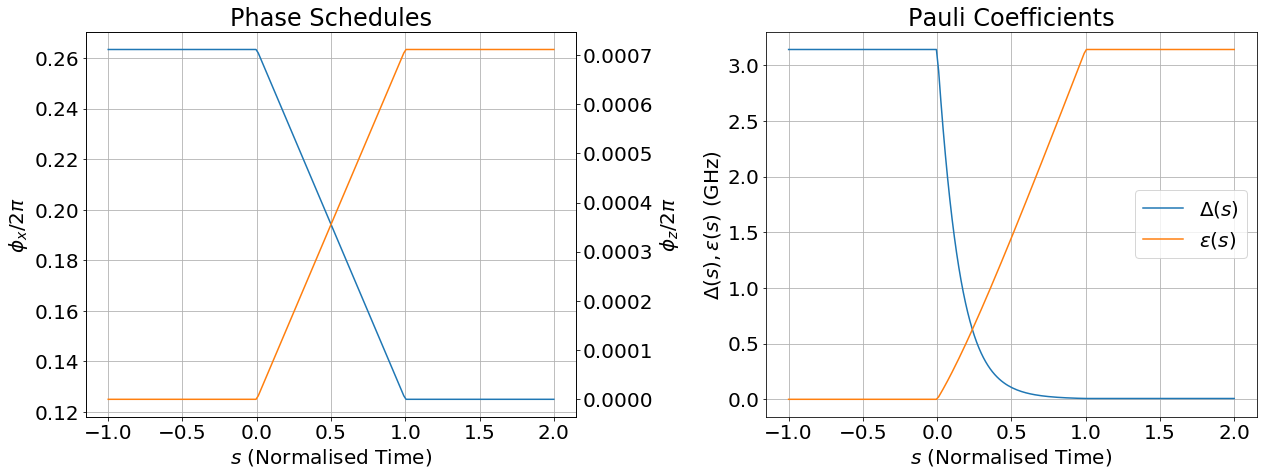

In [26]:
# Phase schedules
fig = plt.figure(figsize=(18,7))
ax11 = plt.subplot(121)
ax11.plot(times/tan, phi_x_p/(2*np.pi))
ax12 = ax11.twinx()
ax12.plot(times/tan, phi_z_p/(2*np.pi),'C1-')
ax11.set_title("Phase Schedules")
ax11.set_xlabel('$s$ (Normalised Time)')
ax11.set_ylabel('$\phi_{x}/2\pi$')
ax12.set_ylabel('$\phi_{z}/2\pi$')
#ax11.legend(("$\phi_x(s)$","$\phi_z(s)$"))
ax11.grid()

# Energy schedules
ax2 = plt.subplot(122)
ax2.plot(times/tan, Apts)
ax2.plot(times/tan, Bpts)
ax2.set_title("Pauli Coefficients")
ax2.set_xlabel('$s$ (Normalised Time)')
ax2.set_ylabel('$\\Delta(s),\\varepsilon(s)$ (GHz)')
ax2.legend(["$\\Delta(s)$","$\\varepsilon(s)$"])
ax2.grid()
fig.tight_layout()

So we can also control the shape of the $\Delta(s)$ schedule to some extent. There are other approaches to this but we will use this for now.

### The Sinusoidal Schedule

In this proposal we base our scheduling on sinewave signals sent by an analogue source. In this case there is much less flexibility in tuning the schedules since it will depend on the qubit circuits themselves. The signals we choose to use are:

$$\phi_x(s) = \phi_{x,o}+\left(\phi_{x,m} - \phi_{x,o}\right)\left[1 - \frac{\sin\left( \pi s/n \right)}{\sin\left( \pi/n \right)} \right]$$

and

$$\phi_z(s) = \phi_{z,o} + \phi_{z,m} \frac{\sin\left( \pi s/n \right)}{\sin\left( \pi/n \right)}$$

where $n$ controls the portion of the sinewave used to define a full anneal. The most practical implementation of this is to choose $n=2$ so that a quarter wave is used at $s=1$ and a half wave is used at $s=2$.

The primary benefit of using an analogue source is in the quasi-continuous choice of frequency available from such a source. For example the SGS100A base unit can source 1 to 6000 MHz high purity signals, and the frequency can be adjusted at a resolution of 1 mHz! To estimate the resolution of annealing time available with this source, we know that

$$t_\mathrm{an} = 0.5 t_\mathrm{RF}$$

where $1/t_\mathrm{RF}$ is the source frequency, so we have

$$t_\mathrm{an} = \frac{1}{2 f_\mathrm{RF}}$$

Then for a change in $t_\mathrm{an}$ we have

$$\frac{dt_\mathrm{an}}{df_\mathrm{RF}} = -\frac{1}{2 f_\mathrm{RF}^2}$$

Using the smallest change available $df_\mathrm{RF} = 0.001$ Hz, and using a starting value of $t_\mathrm{an} = 0.5$ ns, we then get

$$dt_\mathrm{an} = -\frac{df_\mathrm{RF}}{2 f_\mathrm{RF}^2} = -\frac{1\mathrm{e}^{-3}}{2 (1\mathrm{e}^{9})^2} = -5\mathrm{e}^{-22}\,\,\mathrm{s}$$

which is much smaller than we would ever need. A more reasonable value for the frequency step is $df_\mathrm{RF} = 100$ MHz, which gives us a resolution of $50$ ps for the same conditions as above.

Another benefit is the fact that using pure sine waves should mitigate first and second order effects, as the transients are relaxed.

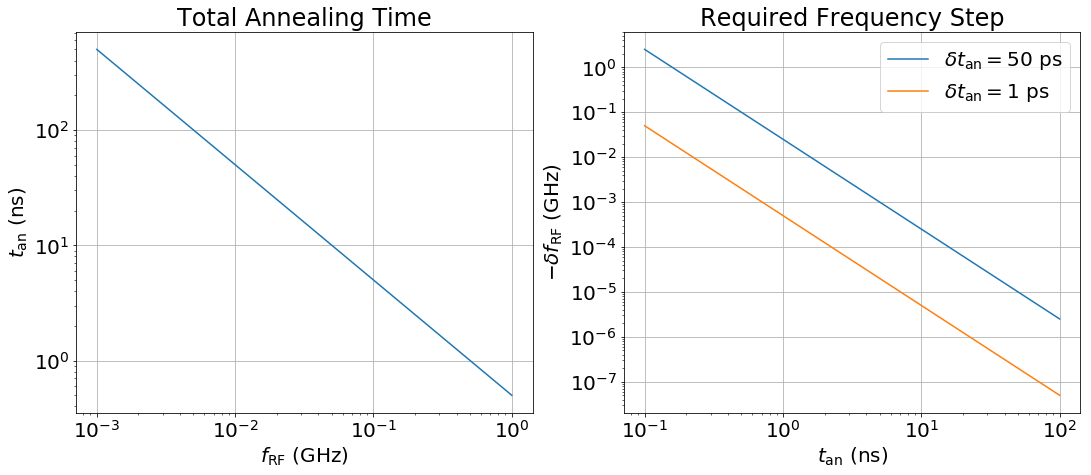

In [27]:
# Total an time
fpts = np.logspace(-3,0)
tpts = np.array([1/(2*f) for f in fpts])

# Resolution required
dtreq1 = 0.05 # ns
dtreq2 = 0.001 # ns
tanpts = np.logspace(-1,2)
dfpts1 = np.array([-2*dtreq1*1/(2*t)**2 for t in tanpts])
dfpts2 = np.array([-2*dtreq2*1/(2*t)**2 for t in tanpts])

# Plot total annealing time as function of RF frequency
fig = plt.figure(figsize=(18,7))

# Total annealing time
ax1 = plt.subplot(121)
ax1.loglog(fpts, tpts)
ax1.set_title("Total Annealing Time")
ax1.set_xlabel('$f_\mathrm{RF}$ (GHz)')
ax1.set_ylabel('$t_\mathrm{an}$ (ns)')
ax1.grid()

ax2 = plt.subplot(122)
ax2.loglog(tanpts, -dfpts1)
ax2.loglog(tanpts, -dfpts2)
ax2.set_title("Required Frequency Step")
ax2.set_xlabel('$t_\mathrm{an}$ (ns)')
ax2.set_ylabel('$-\delta f_\mathrm{RF}$ (GHz)')
ax2.legend(["$\delta t_\mathrm{an} = 50$ ps","$\delta t_\mathrm{an} = 1$ ps"])
ax2.grid()

Ok now let's put together what we have and create the response to these sinusoidal schedules:

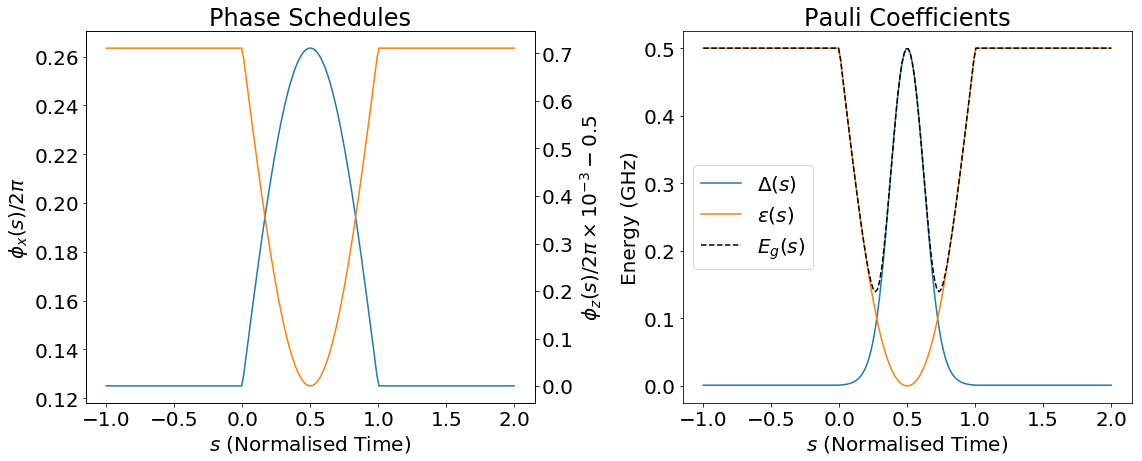

In [28]:
# Sinusoidal schedules
def phi_x_sig(t,p):
    if t < 0:
        return p["x_min"]
    elif t >= 0 and t <= p["tan"]:
        return (p["x_max"] - p["x_min"])*np.sin(t/p["tan"]*np.pi) + p["x_min"]
    else:
        return p["x_min"]

def phi_z_sig(t,p):
    if t < 0:
        return p["z_max"]
    elif t >= 0 and t <= p["tan"]:
        return p["z_max"]*(1-np.sin(t/p["tan"]*np.pi))
    else:
        return p["z_max"]

# Get the pauli coefficients
def AofS(t,p):
    
    # Get params
    Ec = p["Ec"]
    Ej = p["Ej"]
    trunc = p["trunc"]
    
    # Values of phase at current time
    phi_x = phi_x_sig(t,p)
    phi_z = phi_z_sig(t,p)
    
    # Get current A
    A,B = AB_perturbative(phi_x,phi_z)
    return A

def BofS(t,p):
    
    # Get params
    Ec = p["Ec"]
    Ej = p["Ej"]
    trunc = p["trunc"]
    
    # Values of phase at current time
    phi_x = phi_x_sig(t,p)
    phi_z = phi_z_sig(t,p)
    
    # Get current A
    A,B = AB_perturbative(phi_x,phi_z)
    return B

# Get phase points
tan = 10
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
times = np.linspace(-tan,2*tan,200)
phi_x_p = np.array([phi_x_sig(t,p) for t in times])
phi_z_p = np.array([phi_z_sig(t,p) for t in times])

# Get energy points
Apts = []
Bpts = []
for i in range(len(phi_x_p)):
    A,B = AB_perturbative(phi_x_p[i],phi_z_p[i])
    Apts.append(A)
    Bpts.append(B)
Apts = np.array(Apts)
Bpts = np.array(Bpts)

# Phase schedules
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701))
ax11 = ax[0]
ax11.plot(times/tan, phi_x_p/(2*np.pi))
ax12 = ax11.twinx()
ax12.plot(times/tan, phi_z_p/(2*np.pi)*1e3,'C1-')
ax11.set_title("Phase Schedules")
ax11.set_xlabel('$s$ (Normalised Time)')
ax11.set_ylabel('$\phi_{x}(s)/2\pi$')
ax12.set_ylabel('$\phi_{z}(s)/2\pi \\times 10^{-3} - 0.5$')
#ax11.legend(("$\phi_x(s)$","$\phi_z(s)$"))
#ax11.grid()

# Energy schedules
ax2 = ax[1]
ax2.plot(times/tan, Apts/(2*np.pi))
ax2.plot(times/tan, Bpts/(2*np.pi))
ax2.plot(times/tan,np.sqrt(Apts**2 + Bpts**2)/(2*np.pi),'k--')
ax2.set_title("Pauli Coefficients")
ax2.set_xlabel('$s$ (Normalised Time)')
ax2.set_ylabel('Energy (GHz)')
ax2.legend(["$\\Delta(s)$","$\\varepsilon(s)$","$E_g(s)$"],loc=6)
#ax2.grid()
#fig.tight_layout()
#plt.savefig("MappedPauliCoeffs.png")
plt.show()
plt.close()

Ok so we see that with these non-linear responses to the schedules, we create two clear Landau-Zener points which can be tuned to some extent depending on the flux offset and RF amplitudes.

I will add more to this but for now I will leave solving the oscillations as a function of annealing time to you. Keep in mind that solving the oscillations will be quite computationally demanding as it currently stands. Maybe there is a way to optimise this.

Further topics in an update will be:

* Dealing with cross-talk between X and Z loops
* Solving with circuit effects on the bias lines
* Solving for multi-level systems

### Bias Line Circuit Effects

To demonstrate the circuit effects, we transform between the time and Laplace domains. A simplified bias line circuit will take the form shown in the following image:

<img src="simple-circuit-2.png" height="150">

The resistor is used to convert a supplied voltage to a current, which induces a flux in a qubit circuit through a mutual inductance. A finite capacitance will exist between the leads that should have an effect at higher frequencies. The transfer function is derived from

$$Y_\mathrm{T}(s)\,=\,\frac{I_\mathrm{out}(s)}{V_\mathrm{in}(s)}$$

In the circuit shown the transfer function is

$$Y_\mathrm{T}(s)\,=\,\frac{1}{s^2 RLC + sL + R}$$

This is a typical second order differential equation in the Laplace domain. Using the standard notation for the factors of each term we can write

$$Y_\mathrm{T}(s)\,=\,\frac{1}{ms^2 + cs + k}$$

from which we can extract the well known second order system parameters. $c$ is the damping term and is crucial in determining the types of solutions obtained. The critical damping coefficient is

$$c_\mathrm{c}\,=\,2\sqrt{km}$$

and from which the damping ratio can be defined

$$\zeta\,=\,\frac{c}{c_\mathrm{c}}$$

which is useful in predicting the level of damping in the system and types of solutions we will obtain. The natural frequency of the system is 

$$\omega_0\,=\,\sqrt{\frac{k}{m}}$$

Now adopting this notation and simplifying, the transfer function is expressed as

$$Y_\mathrm{T}(s)\,=\,\frac{1}{\sqrt{c^2 - 4km}}\left(\frac{1}{s - s_1} - \frac{1}{s - s_2}\right)$$

where $s_{1,2}$ are the roots to the polynomial in the denominator

$$s_{1,2}\,=\,\frac{-c\pm\sqrt{c^2 - 4km}}{2m}$$

The transfer function is then easily inverse Laplace transformed to the time domain:

$$y_\mathrm{T}(t)\,=\,\frac{1}{\sqrt{c^2 - 4km}}\left(e^{s_1 t} - e^{s_2 t}\right)$$

Knowing the input voltage in the time domain $v_\mathrm{in}(t)$, we can find the current response by convolving with the transfer function

$$i_\mathrm{out}(t) = \int_0^t v_\mathrm{in}(t-\tau)y_\mathrm{T}(\tau)d\tau$$

which is easily done numerically. We will compare this with the result obtained when only using a series resistor, i.e.

$$i_\mathrm{out}(t) = \frac{v_\mathrm{in}(t)}{R}$$

In [29]:
# Circuit lumped parameters
Cce = 10e-12*1e9
Lce = 100e-10*1e9
Rce = 50

# Second order system parameters
m = Lce*Cce*Rce
c = Lce
k = Rce

# Critical damping
cc = 2*np.sqrt(k*m)

# Damping ratio
zeta = c/cc

# Resonant frequency
omega0ce = np.sqrt(k/m)

# Q factor
Qce = 1.0/(2*zeta)

print ("zeta = %e" % zeta)
print ("omega0 = %e GHz" % omega0ce)
print ("T0 = %e ns" % (2*np.pi/omega0ce))
print ("Q = %e" % Qce)

# Check the roots
deltace = np.sqrt(c**2 - 4*m*k + 0.0j)
s12 = [(-c + float(i)*deltace)/(2*m) for i in [1,-1]]
if s12[0] == np.conj(s12[1]):
    print("s_1 and s_2 form complex conjugate pair.")
else:
    print("s_1 and s_2 form unique real solutions.")
s1 = s12[0]
s2 = s12[1]

# Transfer function
#def yt(t):
#    return 1/(delta*k) * (-np.exp(s1*t)*(m*s1**2 + 1) + np.exp(s2*t)*(m*s2**2 + 1))
def yt(t):
    return 1/deltace * (np.exp(s1*t) - np.exp(s2*t))

# Convolution integrand
def convolve_int(tau,t,f,p):
    return sc.real(f(t-tau-sdelay,p)*yt(tau))

# Sinusoidal schedules with circuit effects
def phi_x_sig_ce(t,p):
    return sc.integrate.quad(convolve_int,0,t,args=(t,phi_x_sig,p),epsabs=1e-18)[0]

def phi_z_sig_ce(t,p):
    return sc.integrate.quad(convolve_int,0,t,args=(t,phi_z_sig,p),epsabs=1e-18)[0]

# Get the pauli coefficients with circuit effects
def AofSce(t,p):
    # Values of phase at current time
    phi_x = phi_x_sig_ce(t,p)
    phi_z = phi_z_sig_ce(t,p)
    
    # Get current A
    A,B = AB_perturbative(phi_x,phi_z)
    return A

def BofSce(t,p):
    # Values of phase at current time
    phi_x = phi_x_sig_ce(t,p)
    phi_z = phi_z_sig_ce(t,p)
    
    # Get current A
    A,B = AB_perturbative(phi_x,phi_z)
    return B

# Signal parameters
tan1 = 10
p = {"tan":tan1,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
sdelay = 100.0 # Delay to remove turn-on transient
times1 = np.linspace(sdelay-tan1,2*tan1+sdelay,400)

# Get phase points
phi_x_pce1 = np.array([phi_x_sig_ce(t,p)*Rce for t in times1])
phi_z_pce1 = np.array([phi_z_sig_ce(t,p)*Rce for t in times1])

# Get energy points
Aptsce1 = []
Bptsce1 = []
for i in range(len(phi_x_pce1)):
    A,B = AB_perturbative(phi_x_pce1[i],phi_z_pce1[i])
    Aptsce1.append(A)
    Bptsce1.append(B)
Aptsce1 = np.array(Aptsce1)
Bptsce1 = np.array(Bptsce1)

# Signal parameters
tan2 = 4
p = {"tan":tan2,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
times2 = np.linspace(sdelay-tan2,2*tan2+sdelay,400)

# Get phase points
phi_x_pce2 = np.array([phi_x_sig_ce(t,p)*Rce for t in times2])
phi_z_pce2 = np.array([phi_z_sig_ce(t,p)*Rce for t in times2])

# Get energy points
Aptsce2 = []
Bptsce2 = []
for i in range(len(phi_x_pce2)):
    A,B = AB_perturbative(phi_x_pce2[i],phi_z_pce2[i])
    Aptsce2.append(A)
    Bptsce2.append(B)
Aptsce2 = np.array(Aptsce2)
Bptsce2 = np.array(Bptsce2)

zeta = 3.162278e-01
omega0 = 3.162278e+00 GHz
T0 = 1.986918e+00 ns
Q = 1.581139e+00
s_1 and s_2 form complex conjugate pair.


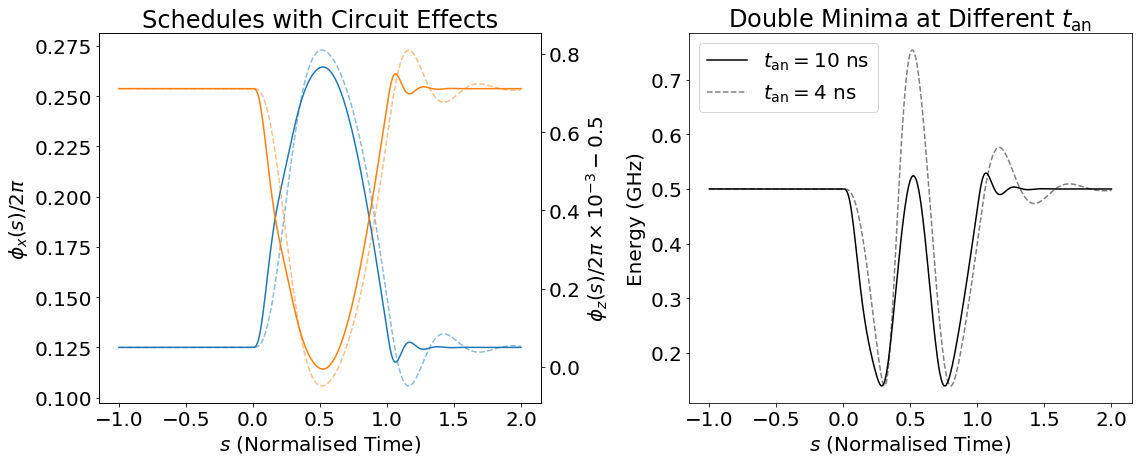

In [30]:
# Phase schedules
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701))
ax11 = ax[0]
ax11.plot((times1-sdelay)/tan1, phi_x_pce1/(2*np.pi),'C0-')
ax11.plot((times2-sdelay)/tan2, phi_x_pce2/(2*np.pi),'C0--',alpha=0.5)
ax12 = ax11.twinx()
ax12.plot((times1-sdelay)/tan1, phi_z_pce1/(2*np.pi)*1e3,'C1-')
ax12.plot((times2-sdelay)/tan2, phi_z_pce2/(2*np.pi)*1e3,'C1--',alpha=0.5)
ax11.set_title("Schedules with Circuit Effects")
ax11.set_xlabel('$s$ (Normalised Time)')
ax11.set_ylabel('$\phi_{x}(s)/2\pi$')
ax12.set_ylabel('$\phi_{z}(s)/2\pi \\times 10^{-3} - 0.5$')
#ax11.legend(("$\phi_x(s)$","$\phi_z(s)$"))
#ax11.grid()

# Energy schedules
ax2 = ax[1]
#ax2.plot((times1-sdelay)/tan1, Aptsce1/(2*np.pi))
#ax2.plot((times1-sdelay)/tan1, Bptsce1/(2*np.pi))
ax2.plot((times1-sdelay)/tan1,np.sqrt(Aptsce1**2 + Bptsce1**2)/(2*np.pi),'k-')
ax2.plot((times2-sdelay)/tan2,np.sqrt(Aptsce2**2 + Bptsce2**2)/(2*np.pi),'k--',alpha=0.5)
ax2.set_title("Double Minima at Different $t_\mathrm{an}$")
ax2.set_xlabel('$s$ (Normalised Time)')
ax2.set_ylabel('Energy (GHz)')
ax2.legend(["$t_\mathrm{an} = 10$ ns","$t_\mathrm{an} = 4$ ns"],loc=2)
#ax2.grid()
#fig.tight_layout()
#plt.savefig("MappedPauliCoeffs_wCE.png")
plt.show()
plt.close()

### Evolving the Circuit Hamiltonian (Closed Case)

We will now look at evolving the full circuit model using the same schedules derived above. This system now includes all the states limited by the truncation of the Hilbert space. First we should look at how the double minimum looks compared to the mapped case.

In [432]:
#
#   CSFQ Hamiltonian with BO approximation and negligible inductance.
#
def Hcsfq_BO_nL_mod(phi_x,phi_z,Jc,Ca,Ajj,alpha,Csh,asy=0.0,Q=None,Dp=None,Dm=None):

    # Asymmetry factor and phase
    asy_f = np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
    asy_p = np.arctan(asy * np.tan(phi_x/2))
    
    # Total capacitance (F)
    Csigma = (0.5+alpha)*Ajj*Ca*1e-15 + Csh
    
    # Charging energy (GHz)
    Ec = 2*pc.e**2/(Csigma*pc.hbar) * 1e-9
    
    # Josephson energy (GHz)
    Ej = Ajj*Jc*pc.phi0/(2*np.pi*pc.hbar) * 1e-15
    
    # Construct Hamiltonian
    H = 0.5*Ec*Q**2 - Ej*(Dp+Dm) + asy_f*0.5*alpha*Ej*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*Dp**2+np.exp(-1j*(phi_z-asy_p))*Dm**2)
    
    # Return relevant parts (convert to rGHz)
    return H

# Hamiltonian for given tan
tan = 10
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
asy=0.0

# Look at instantaneous eigenvalues during flux schedule evolution
times = np.linspace(-tan,2*tan,400)
phi_x_p = np.array([phi_x_sig(t,p) for t in times])
phi_z_p = np.array([phi_z_sig(t,p) for t in times])
Eg1 = []
Eg2 = []
Es = []
for t in times:
    E = np.linalg.eigvalsh(Hcsfq_BO_nL_mod(phi_x_sig(t,p),phi_z_sig(t,p),Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm).data.todense())
    
    # Get the gaps
    Eg1.append(E[1]-E[0])
    Eg2.append(E[2]-E[0])
    Es.append(E)
Eg1 = np.array(Eg1)
Eg2 = np.array(Eg2)
Es = np.array(Es)

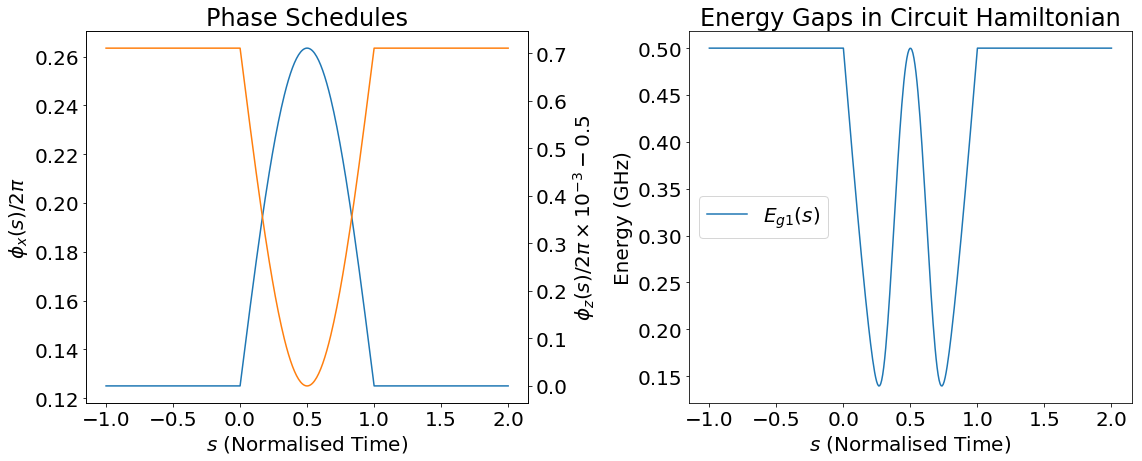

In [433]:
# Phase schedules
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701))
ax11 = ax[0]
ax11.plot(times/tan, phi_x_p/(2*np.pi))
ax12 = ax11.twinx()
ax12.plot(times/tan, phi_z_p/(2*np.pi)*1e3,'C1-')
ax11.set_title("Phase Schedules")
ax11.set_xlabel('$s$ (Normalised Time)')
ax11.set_ylabel('$\phi_{x}(s)/2\pi$')
ax12.set_ylabel('$\phi_{z}(s)/2\pi \\times 10^{-3} - 0.5$')
#ax11.legend(("$\phi_x(s)$","$\phi_z(s)$"))
#ax11.grid()

# Energy schedules
ax2 = ax[1]
ax2.plot(times/tan,Eg1/(2*np.pi))
#ax2.plot(times/tan,Es[:,0]/(2*np.pi))
#ax2.plot(times/tan,Es[:,1]/(2*np.pi))
#ax2.plot(times/tan,Eg2/(2*np.pi))
ax2.set_title("Energy Gaps in Circuit Hamiltonian")
ax2.set_xlabel('$s$ (Normalised Time)')
ax2.set_ylabel('Energy (GHz)')
ax2.legend(["$E_{g1}(s)$","$E_{g2}(s)$"],loc=6)
#ax2.grid()
#fig.tight_layout()
#plt.savefig("MappedPauliCoeffs.png")
plt.show()
plt.close()

To use qutip for state evolution, the Hamiltonian must be expressed as time-independent operators with time-dependent prefactors. This is readily done with the approximate models used above.

In [601]:
#
#   CSFQ Hamiltonian with BO approximation and negligible inductance.
#
def Hcsfq_BO_nL_mod(phi_x,phi_z,Jc,Ca,Ajj,alpha,Csh,asy=0.0,Q=None,Dp=None,Dm=None):

    # Asymmetry factor and phase
    asy_f = np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
    asy_p = np.arctan(asy * np.tan(phi_x/2))
    
    # Total capacitance (F)
    Csigma = (0.5+alpha)*Ajj*Ca*1e-15 + Csh
    
    # Charging energy (GHz)
    Ec = 2*pc.e**2/(Csigma*2*np.pi*pc.hbar) * 1e-9
    
    # Josephson energy (GHz)
    Ej = Ajj*Jc*pc.phi0/(4*np.pi**2*pc.hbar) * 1e-15
    
    # Construct Hamiltonian
    H = 0.5*Ec*Q**2 - Ej*(Dp+Dm) + asy_f*0.5*alpha*Ej*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*Dp**2+np.exp(-1j*(phi_z-asy_p))*Dm**2)
    
    # Return relevant parts (convert to rGHz)
    return H*2*np.pi

# Time dependent operator prefactors
def coef1(t,p):
    return np.cos(phi_x_sig(t,p)/2)*np.exp(1j*(phi_z_sig(t,p)))
def coef2(t,p):
    return np.cos(phi_x_sig(t,p)/2)*np.exp(-1j*(phi_z_sig(t,p)))

# Range of annealing times
tf_min = 0.0
tf_max = 15.0
tf = np.linspace(tf_min,tf_max,601)

# Hamiltonian at t=0
tan = 1
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
asy=0.0
H0 = Hcsfq_BO_nL_mod(phi_x_sig(0,p),phi_z_sig(0,p),Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm)

# Get the ground state at t=0 with eigenvalue E0
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# Asymmetry factor and phase
asy_f = 0#np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
asy_p = 0#np.arctan(asy * np.tan(phi_x/2))

# Total capacitance (F)
Csigma = (0.5+alpha)*Ajj*Ca*1e-15 + Csh

# Charging energy (rGHz)
Ec = 2*pc.e**2/(Csigma*pc.hbar) * 1e-9

# Josephson energy (rGHz)
Ej = Ajj*Jc*pc.phi0/(2*np.pi*pc.hbar) * 1e-15

# Full annealing Hamiltonian
# Using qutips functional time dependence array structure
Hti = 0.5*Ec*Q**2 - Ej*(Dp+Dm)
H1 = 0.5*alpha*Ej*Dp**2
H2 = 0.5*alpha*Ej*Dm**2
H = [Hti,[H1,coef1],[H2,coef2]]

# Setup progress bar
f = FloatProgress(min=0, max=len(tf))
display(f)

# Use the Lindblad master equation solver
p0_cm = []#np.zeros(len(tf))
final_dms = []
final_states = []
steps = 400000
for i,tan in enumerate(tf):
    times = np.array([0.0,tan])
    
    # A and B arguments
    argss = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation.
    result = None
    while True:
        try:
            result = qt.mesolve(H, psi0, times, [], [], args=argss,options=qt.Options(nsteps=steps))
            steps = 400000
            break
        except Exception: # Increase the step size if fails
            steps *= 2
    
    # Save the probability of finding original ground state (reverse-forward protocol)
    #p0_cm[i] = qt.expect(qt.ket2dm(result.states[-1]),psi0)
    p0_cm.append(qt.expect(qt.ket2dm(result.states[-1]),psi0))
    
    # Save the final density matrix (used to calculate probabilities of being in higher excited states)
    final_dms.append(qt.ket2dm(result.states[-1]))
    
    # Save the actual states for looking at relative phases
    final_states.append([result.states[0],result.states[-1]])
    print ("Iteration %i done." % i)


FloatProgress(value=0.0, max=601.0)

Iteration 0 done.
Iteration 1 done.
Iteration 2 done.
Iteration 3 done.
Iteration 4 done.
Iteration 5 done.
Iteration 6 done.
Iteration 7 done.
Iteration 8 done.
Iteration 9 done.
Iteration 10 done.
Iteration 11 done.
Iteration 12 done.
Iteration 13 done.
Iteration 14 done.
Iteration 15 done.
Iteration 16 done.
Iteration 17 done.
Iteration 18 done.
Iteration 19 done.
Iteration 20 done.
Iteration 21 done.
Iteration 22 done.
Iteration 23 done.
Iteration 24 done.
Iteration 25 done.
Iteration 26 done.
Iteration 27 done.
Iteration 28 done.
Iteration 29 done.
Iteration 30 done.
Iteration 31 done.
Iteration 32 done.
Iteration 33 done.
Iteration 34 done.
Iteration 35 done.
Iteration 36 done.
Iteration 37 done.
Iteration 38 done.
Iteration 39 done.
Iteration 40 done.
Iteration 41 done.
Iteration 42 done.
Iteration 43 done.
Iteration 44 done.
Iteration 45 done.
Iteration 46 done.
Iteration 47 done.
Iteration 48 done.
Iteration 49 done.
Iteration 50 done.
Iteration 51 done.
Iteration 52 done.
Ite

Iteration 416 done.
Iteration 417 done.
Iteration 418 done.
Iteration 419 done.
Iteration 420 done.
Iteration 421 done.
Iteration 422 done.
Iteration 423 done.
Iteration 424 done.
Iteration 425 done.
Iteration 426 done.
Iteration 427 done.
Iteration 428 done.
Iteration 429 done.
Iteration 430 done.
Iteration 431 done.
Iteration 432 done.
Iteration 433 done.
Iteration 434 done.
Iteration 435 done.
Iteration 436 done.
Iteration 437 done.
Iteration 438 done.
Iteration 439 done.
Iteration 440 done.
Iteration 441 done.
Iteration 442 done.
Iteration 443 done.
Iteration 444 done.
Iteration 445 done.
Iteration 446 done.
Iteration 447 done.
Iteration 448 done.
Iteration 449 done.
Iteration 450 done.
Iteration 451 done.
Iteration 452 done.
Iteration 453 done.
Iteration 454 done.
Iteration 455 done.
Iteration 456 done.
Iteration 457 done.
Iteration 458 done.
Iteration 459 done.
Iteration 460 done.
Iteration 461 done.
Iteration 462 done.
Iteration 463 done.
Iteration 464 done.
Iteration 465 done.


ValueError: x and y must have same first dimension, but have shapes (201,) and (601,)

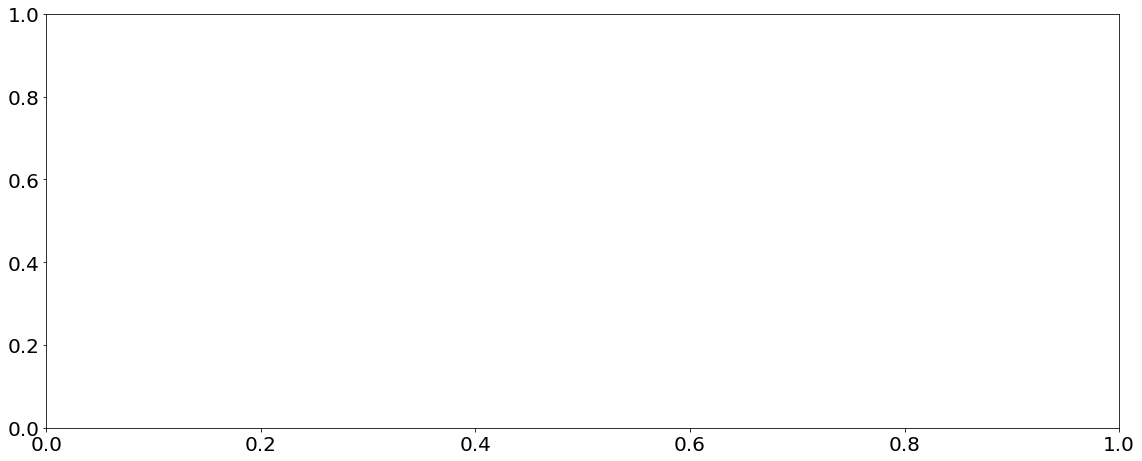

In [31]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

# Oscillations
#ax.plot(tf, [qt.expect(x,psi0) for x in final_dms])
ax.plot(tf, p0_cm,label="$\\langle\\psi_0|\\hat{\\rho}_z|\\psi_0\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[1]) for x in final_dms],label="$\\langle\\psi_1|\\hat{\\rho}_z|\\psi_1\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[2]) for x in final_dms],label="$\\langle\\psi_2|\\hat{\\rho}_z|\\psi_2\\rangle$")
ax.plot([tf_min,tf_max],[1.0,1.0],"k--")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend(loc=1)
plt.savefig("FullCH-Oscillations-2.png")
plt.show()
plt.close()

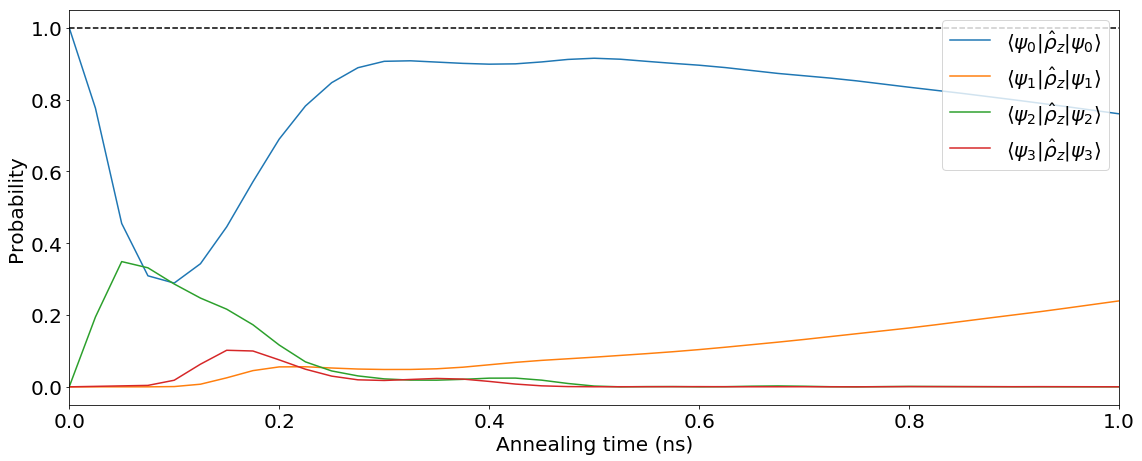

In [440]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

# Oscillations
#ax.plot(tf, [qt.expect(x,psi0) for x in final_dms])
ax.plot(tf, p0_cm,label="$\\langle\\psi_0|\\hat{\\rho}_z|\\psi_0\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[1]) for x in final_dms],label="$\\langle\\psi_1|\\hat{\\rho}_z|\\psi_1\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[2]) for x in final_dms],label="$\\langle\\psi_2|\\hat{\\rho}_z|\\psi_2\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[3]) for x in final_dms],label="$\\langle\\psi_3|\\hat{\\rho}_z|\\psi_3\\rangle$")
ax.plot([tf_min,tf_max],[1.0,1.0],"k--")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.set_xlim(0,1)
ax.legend(loc=1)
plt.savefig("FullCH-Oscillations-2-Zoomed.png")
plt.show()
plt.close()

### Evolving the Circuit Hamiltonian (Open Case)

We will try to evole the circuit Hamitonian when coupled to the environment through the charge degree of freedom. Following from [Tameem *et al.*](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.91.062320), we can simulate decoherence in the singular coupling limit (SCL) with qutip as the Lindbladians are time-independent (Eqs. 13a-b).

What doesn't seem very clear to me is [the statement that](http://qutip.org/docs/4.1/guide/dynamics/dynamics-master.html#the-lindblad-master-equation)

$$\tau_\mathrm{sys} \gg \tau_\mathrm{env}$$

must be satisfied (short memory environment), which appears to be consistent with Tameem's description, but in the examples following these statements the rate associated with decay $\gamma(0)$ is set much smaller than the energy scale of the system ($0.05/2\pi$ GHz for environment vs $0.1$ GHz for the system, or have I misinterpreted??).

In the SCL, decoherence occurs in the basis that diagonalises the coupled operator. So if we choose the charge operator $\hat{Q}$, it's eigenstates are the Foch states, which are chosen as the computational basis. Therefore the decoherence corresponds to dephasing in the computational basis, with associated time constant

$$T_2 = \frac{1}{2 \gamma(0)}$$

In [442]:
#
#   CSFQ Hamiltonian with BO approximation and negligible inductance.
#
def Hcsfq_BO_nL_mod(phi_x,phi_z,Jc,Ca,Ajj,alpha,Csh,asy=0.0,Q=None,Dp=None,Dm=None):

    # Asymmetry factor and phase
    asy_f = np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
    asy_p = np.arctan(asy * np.tan(phi_x/2))
    
    # Total capacitance (F)
    Csigma = (0.5+alpha)*Ajj*Ca*1e-15 + Csh
    
    # Charging energy (GHz)
    Ec = 2*pc.e**2/(Csigma*2*np.pi*pc.hbar) * 1e-9
    
    # Josephson energy (GHz)
    Ej = Ajj*Jc*pc.phi0/(4*np.pi**2*pc.hbar) * 1e-15
    
    # Construct Hamiltonian
    H = 0.5*Ec*Q**2 - Ej*(Dp+Dm) + asy_f*0.5*alpha*Ej*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*Dp**2+np.exp(-1j*(phi_z-asy_p))*Dm**2)
    
    # Return relevant parts (convert to rGHz)
    return H*2*np.pi

# Time dependent operator prefactors
def coef1(t,p):
    return np.cos(phi_x_sig(t,p)/2)*np.exp(1j*(phi_z_sig(t,p)))
def coef2(t,p):
    return np.cos(phi_x_sig(t,p)/2)*np.exp(-1j*(phi_z_sig(t,p)))

# Range of annealing times
tf_min = 0.0
tf_max = 15.0
tf = np.linspace(tf_min,tf_max,601)

# Hamiltonian at t=0
tan = 1
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
asy=0.0
H0 = Hcsfq_BO_nL_mod(phi_x_sig(0,p),phi_z_sig(0,p),Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm)

# Get the ground state at t=0 with eigenvalue E0
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# Asymmetry factor and phase
asy_f = 0#np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
asy_p = 0#np.arctan(asy * np.tan(phi_x/2))

# Total capacitance (F)
Csigma = (0.5+alpha)*Ajj*Ca*1e-15 + Csh

# Charging energy (rGHz)
Ec = 2*pc.e**2/(Csigma*pc.hbar) * 1e-9

# Josephson energy (rGHz)
Ej = Ajj*Jc*pc.phi0/(2*np.pi*pc.hbar) * 1e-15

# Full annealing Hamiltonian
# Using qutips functional time dependence array structure
Hti = 0.5*Ec*Q**2 - Ej*(Dp+Dm)
H1 = 0.5*alpha*Ej*Dp**2
H2 = 0.5*alpha*Ej*Dm**2
H = [Hti,[H1,coef1],[H2,coef2]]

# Setup progress bar
f = FloatProgress(min=0, max=len(tf))
display(f)

# Use the Lindblad master equation solver
p0_cmo = []#np.zeros(len(tf))
final_dmso = []
steps = 400000
for i,tan in enumerate(tf):
    times = np.array([0.0,tan])
    
    # A and B arguments
    argss = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation.
    result = None
    while True:
        try:
            result = qt.mesolve(H, psi0, times, [np.sqrt(0.005)*Q], [], args=argss,options=qt.Options(nsteps=steps))
            steps = 400000
            break
        except Exception: # Increase the step size if fails
            steps *= 2
    
    # Save the probability of finding original ground state (reverse-forward protocol)
    #p0_cm[i] = qt.expect(qt.ket2dm(result.states[-1]),psi0)
    p0_cmo.append(qt.expect(result.states[-1],psi0))
    
    # Save the final density matrix (used to calculate probabilities of being in higher excited states)
    final_dmso.append(result.states[-1])
    f.value+=1


FloatProgress(value=0.0, max=601.0)

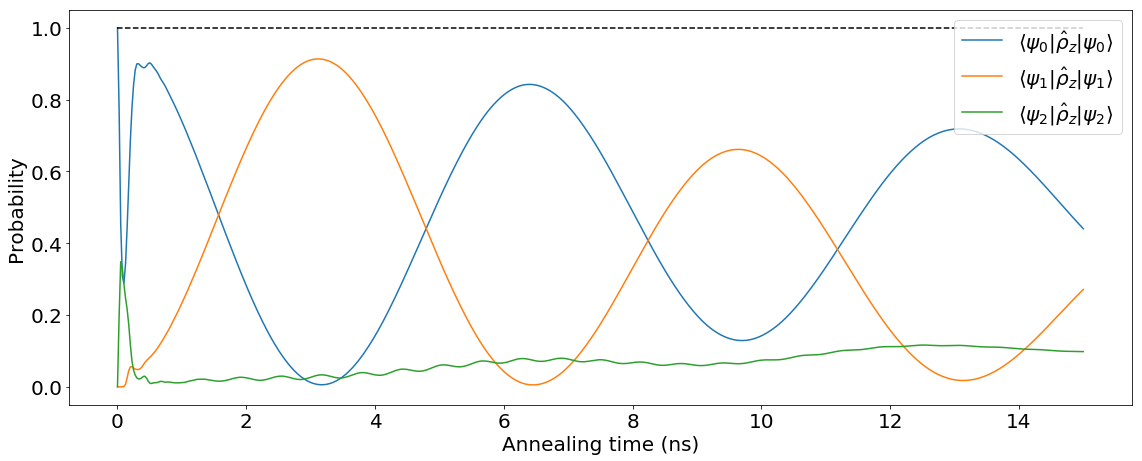

In [443]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

# Oscillations
#ax.plot(tf, [qt.expect(x,psi0) for x in final_dms])
ax.plot(tf, p0_cmo,label="$\\langle\\psi_0|\\hat{\\rho}_z|\\psi_0\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[1]) for x in final_dmso],label="$\\langle\\psi_1|\\hat{\\rho}_z|\\psi_1\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[2]) for x in final_dmso],label="$\\langle\\psi_2|\\hat{\\rho}_z|\\psi_2\\rangle$")
ax.plot([tf_min,tf_max],[1.0,1.0],"k--")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.legend(loc=1)
plt.savefig("FullCH-Oscillations-2-SCL.png")
plt.show()
plt.close()

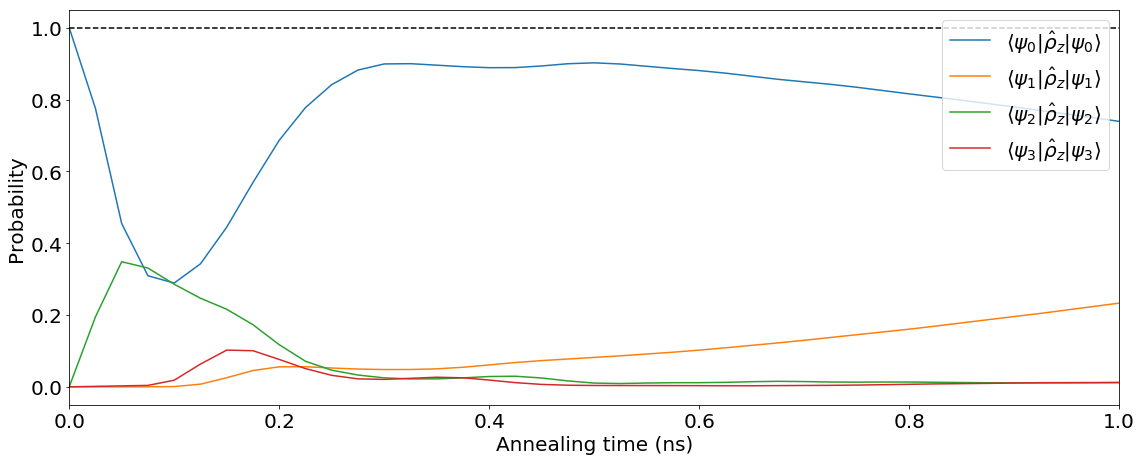

In [444]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

# Oscillations
#ax.plot(tf, [qt.expect(x,psi0) for x in final_dms])
ax.plot(tf, p0_cmo,label="$\\langle\\psi_0|\\hat{\\rho}_z|\\psi_0\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[1]) for x in final_dmso],label="$\\langle\\psi_1|\\hat{\\rho}_z|\\psi_1\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[2]) for x in final_dmso],label="$\\langle\\psi_2|\\hat{\\rho}_z|\\psi_2\\rangle$")
ax.plot(tf, [qt.expect(x,psi_i[3]) for x in final_dmso],label="$\\langle\\psi_3|\\hat{\\rho}_z|\\psi_3\\rangle$")
ax.plot([tf_min,tf_max],[1.0,1.0],"k--")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Probability')
ax.set_xlim(0,1)
ax.legend(loc=1)
plt.savefig("FullCH-Oscillations-2-SCL-Zoomed.png")
plt.show()
plt.close()

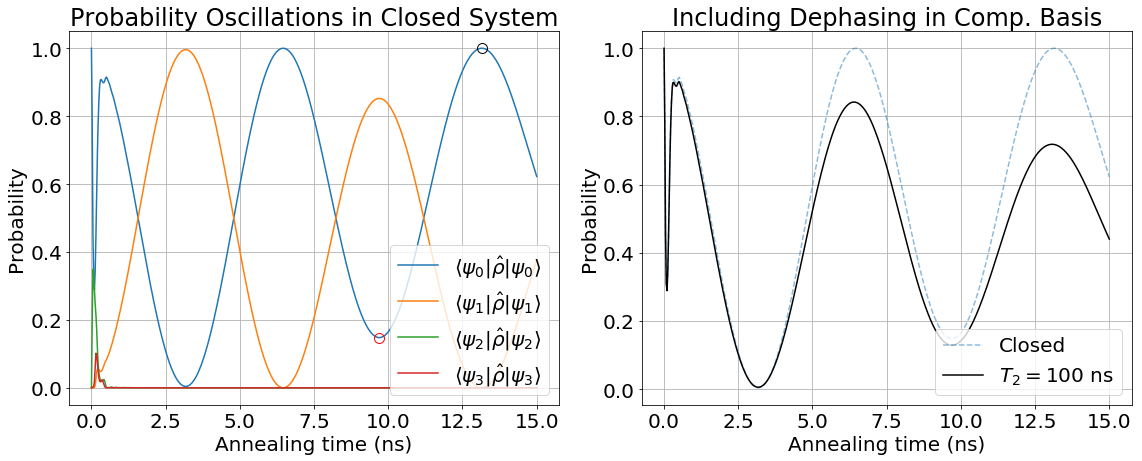

In [513]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701))
ax1 = ax[1]
ax2 = ax[0]

# Open/Closed system comparison
ax1.set_title("Including Dephasing in Comp. Basis")
#ax.plot(tf, [qt.expect(x,psi0) for x in final_dms])
ax1.plot(tf, p0_cm,"C0--",label="Closed",alpha=0.5)
ax1.plot(tf, p0_cmo,"k-",label="$T_2 = 100$ ns")
#ax1.plot(tf,np.exp(-tf/40.0))
#ax1.plot(tf, [qt.expect(x,psi_i[1]) for x in final_dmso],label="$\\langle\\psi_1|\\hat{\\rho}_z|\\psi_1\\rangle$")
#ax1.plot(tf, [qt.expect(x,psi_i[2]) for x in final_dmso],label="$\\langle\\psi_2|\\hat{\\rho}_z|\\psi_2\\rangle$")
#ax1.plot([tf_min,tf_max],[1.0,1.0],"k--")
ax1.grid()
ax1.set_xlabel('Annealing time (ns)')
ax1.set_ylabel('Probability')
ax1.legend(loc=4)

# Closed system oscillations
peak_list=scs.find_peaks(p0_cm)[0]
min_list=scs.find_peaks(1-np.array(p0_cm))[0]
times = np.linspace(-tan,2*tan,400)
ax2.plot(tf, p0_cm,label="$\\langle\\psi_0|\\hat{\\rho}|\\psi_0\\rangle$")
ax2.plot(tf, [qt.expect(x,psi_i[1]) for x in final_dms],label="$\\langle\\psi_1|\\hat{\\rho}|\\psi_1\\rangle$")
ax2.plot(tf, [qt.expect(x,psi_i[2]) for x in final_dms],label="$\\langle\\psi_2|\\hat{\\rho}|\\psi_2\\rangle$")
ax2.plot(tf, [qt.expect(x,psi_i[3]) for x in final_dms],label="$\\langle\\psi_3|\\hat{\\rho}|\\psi_3\\rangle$")
ax2.plot([tf[peak_list[3]]],[p0_cm[peak_list[3]]],"ko",markersize=10,fillstyle='none')
ax2.plot([tf[min_list[3]]],[p0_cm[min_list[3]]],"ro",markersize=10,fillstyle='none')
ax2.grid()
ax2.set_title("Probability Oscillations in Closed System")
ax2.set_xlabel('Annealing time (ns)')
ax2.set_ylabel('Probability')
ax2.legend(loc=4)

plt.savefig("Oscillations-Final.png")
plt.show()
plt.close()

## State Evolution During the Anneal

We can look at the state evolution during the anneal for the points marked in the plot above in the closed case.

In [593]:
tan = tf[peak_list[2]]

# Use the Lindblad master equation solver
steps = 400000
times_con = [-tan]
for t in np.linspace(0,tan,301):
    times_con.append(t)
times_con.append(2*tan)
times_con = np.array(times_con)

# Hamiltonian at t=0
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
asy=0.0
H0 = Hcsfq_BO_nL_mod(phi_x_sig(times_con[0],p),phi_z_sig(times_con[0],p),Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm)

# Get the ground state at start
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# A and B arguments
argss = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}

# Use time dependent Hamiltonian and specify initial state
# Unitary evolution: No dissipation.
result_con = qt.mesolve(H, psi0, times_con, [], [], args=argss,options=qt.Options(nsteps=steps))

# Get the probability of finding original ground state (reverse-forward protocol)
p0_tan_con = np.array([qt.expect(qt.ket2dm(psi),psi0) for psi in result_con.states])

# Save the final density matrix (used to calculate probabilities of being in higher excited states)
dm_tan_con = np.array([qt.ket2dm(psi) for psi in result_con.states])


In [594]:
tan = tf[min_list[2]]

# Use the Lindblad master equation solver
p0_tan = []
dm_tan = []
steps = 400000
times_des = [-tan]
for t in np.linspace(0,tan,301):
    times_des.append(t)
times_des.append(2*tan)
times_des = np.array(times_des)

# Hamiltonian at t=0
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
asy=0.0
H0 = Hcsfq_BO_nL_mod(phi_x_sig(times_des[0],p),phi_z_sig(times_des[0],p),Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm)

# Get the ground state at start
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# A and B arguments
argss = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}

# Use time dependent Hamiltonian and specify initial state
# Unitary evolution: No dissipation.
result_des = qt.mesolve(H, psi0, times_des, [], [], args=argss,options=qt.Options(nsteps=steps))

# Get the probability of finding original ground state (reverse-forward protocol)
p0_tan_des = np.array([qt.expect(qt.ket2dm(psi),psi0) for psi in result_des.states])

# Save the final density matrix (used to calculate probabilities of being in higher excited states)
dm_tan_des = np.array([qt.ket2dm(psi) for psi in result_des.states])


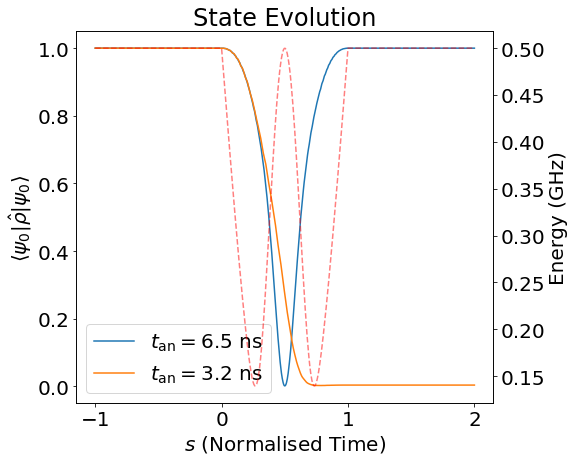

In [595]:
# Plot the evolution of the probability of being in the ground state
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(20*0.393701,16*0.393701))
ax11 = ax
ax11.plot(times_con/tf[peak_list[2]], p0_tan_con,label="$t_\mathrm{an} = %.1f$ ns" % (tf[peak_list[2]]))
ax11.plot(times_des/tf[min_list[2]], p0_tan_des,label="$t_\mathrm{an} = %.1f$ ns" % (tf[min_list[2]]))
ax12 = ax11.twinx()
timesE = np.linspace(-tan,2*tan,400)
ax12.plot(timesE/tan, Eg1/(2*np.pi),"r--",alpha=0.5)
ax11.set_title("State Evolution")
ax11.set_xlabel('$s$ (Normalised Time)')
ax11.set_ylabel('$\\langle\\psi_0|\\hat{\\rho}|\\psi_0\\rangle$')
ax12.set_ylabel('Energy (GHz)')
ax11.legend(loc=3)

## Look at the Amplitudes

Let's see if the amplitudes can say anything about interference. We can extract them as

$$\alpha(t) = \langle g | \psi(t) \rangle$$

and

$$\beta(t) = \langle e | \psi(t) \rangle$$

We can look at the phase of the states during the anneal. We should expect that destructive interference occurs when the relative phase between the states is an odd multiple of $\pi$, and constructive interference when the phase is an even multiple.

In [596]:
alpha_p_con = np.array([np.angle((psi0.dag()*psi)[0][0][0])*180/np.pi for psi in result_con.states])
beta_p_con = np.array([np.angle((psi_i[1].dag()*psi)[0][0][0])*180/np.pi for psi in result_con.states])

alpha_a_con = np.array([np.absolute((psi0.dag()*psi)[0][0][0])*180/np.pi for psi in result_con.states])
beta_a_con = np.array([np.absolute((psi_i[1].dag()*psi)[0][0][0])*180/np.pi for psi in result_con.states])

alpha_p_des = np.array([np.angle((psi0.dag()*psi)[0][0][0])*180/np.pi for psi in result_des.states])
beta_p_des = np.array([np.angle((psi_i[1].dag()*psi)[0][0][0])*180/np.pi for psi in result_des.states])

alpha_a_des = np.array([np.absolute((psi0.dag()*psi)[0][0][0])*180/np.pi for psi in result_des.states])
beta_a_des = np.array([np.absolute((psi_i[1].dag()*psi)[0][0][0])*180/np.pi for psi in result_des.states])

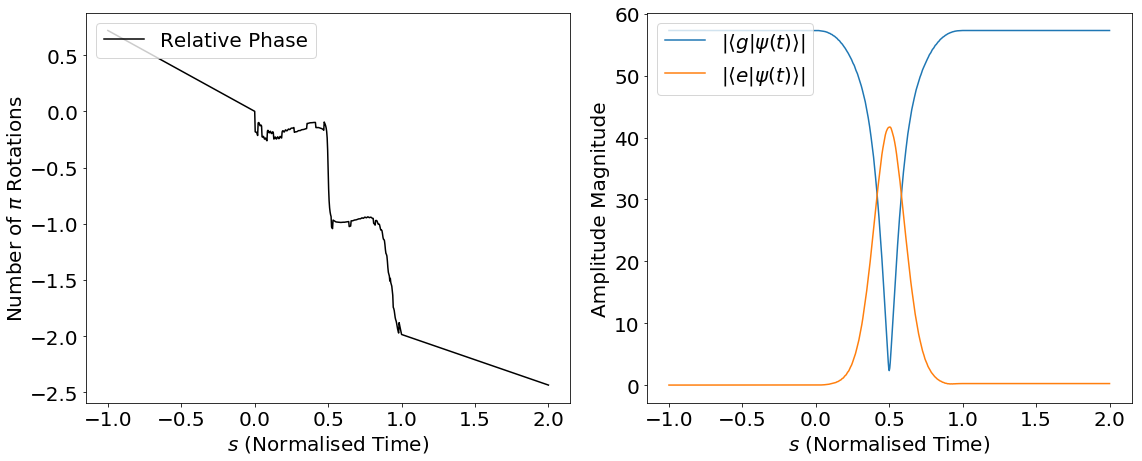

In [597]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

rel_phase_con = (np.unwrap(beta_p_con,discont=180)-np.unwrap(alpha_p_con,discont=180))/180

# Amplitude phases
#ax[0].plot(times_con/tf[peak_list[2]], np.unwrap(alpha_p_con,discont=180),label="$\\arg{\\langle g | \\psi(t) \\rangle}$")
#ax[0].plot(times_con/tf[peak_list[2]], np.unwrap(beta_p_con,discont=180),label="$\\arg{\\langle e | \\psi(t) \\rangle}$")
ax[0].plot(times_con/tf[peak_list[2]], rel_phase_con-rel_phase_con[1],"k-",label="Relative Phase")
ax[0].set_xlabel('$s$ (Normalised Time)')
ax[0].set_ylabel('Number of $\pi$ Rotations')
ax[0].legend(loc=2)

# Amplitude magnitudes
ax[1].plot(times_con/tf[peak_list[2]], alpha_a_con,label="$|\\langle g | \\psi(t) \\rangle|$")
ax[1].plot(times_con/tf[peak_list[2]], beta_a_con,label="$|\\langle e | \\psi(t) \\rangle|$")
ax[1].set_xlabel('$s$ (Normalised Time)')
ax[1].set_ylabel('Amplitude Magnitude')
ax[1].legend(loc=2)

plt.show()
plt.close()

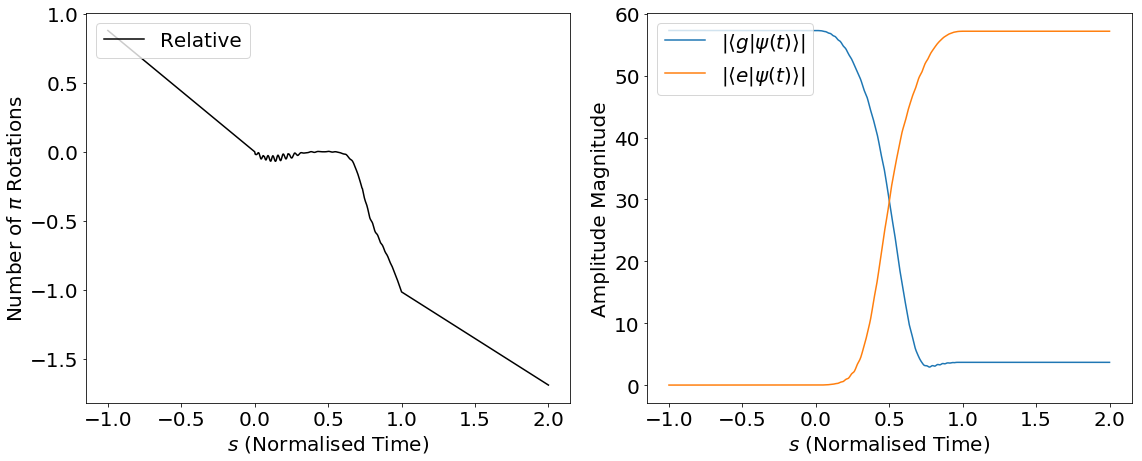

In [598]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

rel_phase_des = (np.unwrap(beta_p_des,discont=180) - np.unwrap(alpha_p_des,discont=180))/180

# Amplitude phases
#ax[0].plot(times_des/tf[min_list[2]], np.unwrap(alpha_p_des,discont=180),label="$\\arg{\\langle g | \\psi(t) \\rangle}$")
#ax[0].plot(times_des/tf[min_list[2]], np.unwrap(beta_p_des,discont=180),label="$\\arg{\\langle e | \\psi(t) \\rangle}$")
ax[0].plot(times_des/tf[min_list[2]], rel_phase_des-rel_phase_des[1],"k-",label="Relative")
ax[0].set_xlabel('$s$ (Normalised Time)')
ax[0].set_ylabel('Number of $\pi$ Rotations')
ax[0].legend(loc=2)

# Amplitude magnitudes
ax[1].plot(times_des/tf[min_list[2]], alpha_a_des,label="$|\\langle g | \\psi(t) \\rangle|$")
ax[1].plot(times_des/tf[min_list[2]], beta_a_des,label="$|\\langle e | \\psi(t) \\rangle|$")
ax[1].set_xlabel('$s$ (Normalised Time)')
ax[1].set_ylabel('Amplitude Magnitude')
ax[1].legend(loc=2)

plt.show()
plt.close()

In [583]:
tf[peak_list[2]]

6.45

In [585]:
tan = tf[peak_list[3]]

# Use the Lindblad master equation solver
steps = 400000
times_con = [-tan]
for t in np.linspace(0,tan,301):
    times_con.append(t)
times_con.append(2*tan)
times_con = np.array(times_con)

# Hamiltonian at t=0
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
asy=0.0
H0 = Hcsfq_BO_nL_mod(phi_x_sig(times_con[0],p),phi_z_sig(times_con[0],p),Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm)

# Get the ground state at start
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# A and B arguments
argss = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}

# Use time dependent Hamiltonian and specify initial state
# Unitary evolution: No dissipation.
result_con = qt.mesolve(H, psi0, times_con, [], [], args=argss,options=qt.Options(nsteps=steps))

# Get the probability of finding original ground state (reverse-forward protocol)
p0_tan_con = np.array([qt.expect(qt.ket2dm(psi),psi0) for psi in result_con.states])

# Save the final density matrix (used to calculate probabilities of being in higher excited states)
dm_tan_con = np.array([qt.ket2dm(psi) for psi in result_con.states])


In [586]:
tan = tf[min_list[3]]

# Use the Lindblad master equation solver
p0_tan = []
dm_tan = []
steps = 400000
times_des = [-tan]
for t in np.linspace(0,tan,301):
    times_des.append(t)
times_des.append(2*tan)
times_des = np.array(times_des)

# Hamiltonian at t=0
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
asy=0.0
H0 = Hcsfq_BO_nL_mod(phi_x_sig(times_des[0],p),phi_z_sig(times_des[0],p),Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm)

# Get the ground state at start
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# A and B arguments
argss = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}

# Use time dependent Hamiltonian and specify initial state
# Unitary evolution: No dissipation.
result_des = qt.mesolve(H, psi0, times_des, [], [], args=argss,options=qt.Options(nsteps=steps))

# Get the probability of finding original ground state (reverse-forward protocol)
p0_tan_des = np.array([qt.expect(qt.ket2dm(psi),psi0) for psi in result_des.states])

# Save the final density matrix (used to calculate probabilities of being in higher excited states)
dm_tan_des = np.array([qt.ket2dm(psi) for psi in result_des.states])


In [587]:
alpha_p_con = np.array([np.angle((psi0.dag()*psi)[0][0][0])*180/np.pi for psi in result_con.states])
beta_p_con = np.array([np.angle((psi_i[1].dag()*psi)[0][0][0])*180/np.pi for psi in result_con.states])

alpha_a_con = np.array([np.absolute((psi0.dag()*psi)[0][0][0])*180/np.pi for psi in result_con.states])
beta_a_con = np.array([np.absolute((psi_i[1].dag()*psi)[0][0][0])*180/np.pi for psi in result_con.states])

alpha_p_des = np.array([np.angle((psi0.dag()*psi)[0][0][0])*180/np.pi for psi in result_des.states])
beta_p_des = np.array([np.angle((psi_i[1].dag()*psi)[0][0][0])*180/np.pi for psi in result_des.states])

alpha_a_des = np.array([np.absolute((psi0.dag()*psi)[0][0][0])*180/np.pi for psi in result_des.states])
beta_a_des = np.array([np.absolute((psi_i[1].dag()*psi)[0][0][0])*180/np.pi for psi in result_des.states])

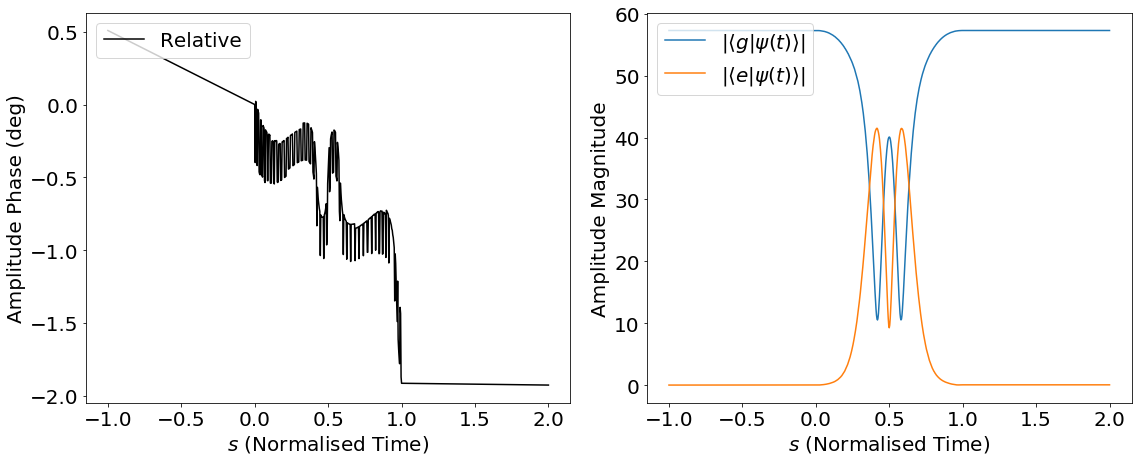

In [589]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

rel_phase_con = (np.unwrap(beta_p_con,discont=180)-np.unwrap(alpha_p_con,discont=180))/180

# Amplitude phases
#ax[0].plot(times_con/tf[peak_list[3]], np.unwrap(alpha_p_con,discont=180),label="$\\arg{\\langle g | \\psi(t) \\rangle}$")
#ax[0].plot(times_con/tf[peak_list[3]], np.unwrap(beta_p_con,discont=180),label="$\\arg{\\langle e | \\psi(t) \\rangle}$")
ax[0].plot(times_con/tf[peak_list[3]], rel_phase_con-rel_phase_con[1],"k-",label="Relative")
ax[0].set_xlabel('$s$ (Normalised Time)')
ax[0].set_ylabel('Amplitude Phase (deg)')
ax[0].legend(loc=2)

# Amplitude magnitudes
ax[1].plot(times_con/tf[peak_list[3]], alpha_a_con,label="$|\\langle g | \\psi(t) \\rangle|$")
ax[1].plot(times_con/tf[peak_list[3]], beta_a_con,label="$|\\langle e | \\psi(t) \\rangle|$")
ax[1].set_xlabel('$s$ (Normalised Time)')
ax[1].set_ylabel('Amplitude Magnitude')
ax[1].legend(loc=2)

plt.show()
plt.close()

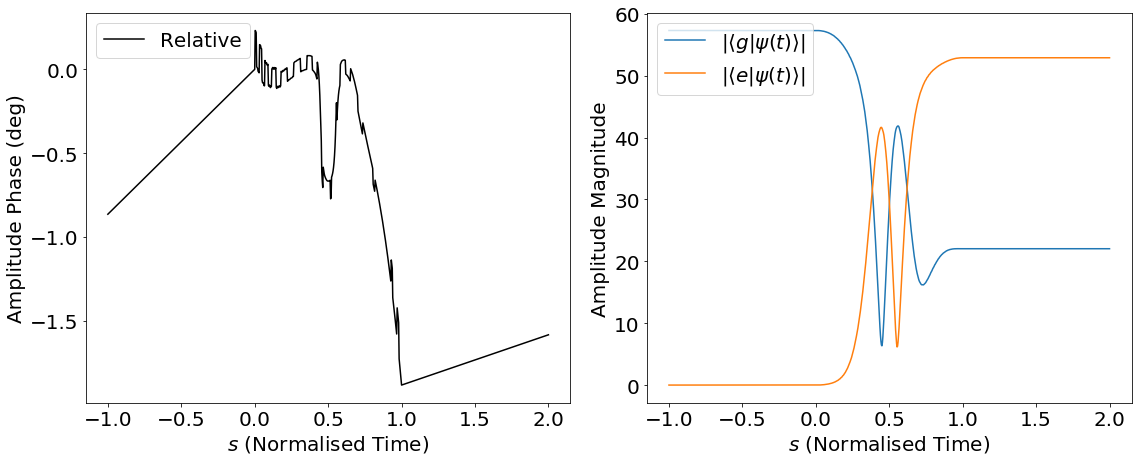

In [590]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,2,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

rel_phase_des = (np.unwrap(beta_p_des,discont=180) - np.unwrap(alpha_p_des,discont=180))/180

# Amplitude phases
#ax[0].plot(times_des/tf[min_list[3]], np.unwrap(alpha_p_des,discont=180),label="$\\arg{\\langle g | \\psi(t) \\rangle}$")
#ax[0].plot(times_des/tf[min_list[3]], np.unwrap(beta_p_des,discont=180),label="$\\arg{\\langle e | \\psi(t) \\rangle}$")
ax[0].plot(times_des/tf[min_list[3]], rel_phase_des-rel_phase_des[1],"k-",label="Relative")
ax[0].set_xlabel('$s$ (Normalised Time)')
ax[0].set_ylabel('Amplitude Phase (deg)')
ax[0].legend(loc=2)

# Amplitude magnitudes
ax[1].plot(times_des/tf[min_list[3]], alpha_a_des,label="$|\\langle g | \\psi(t) \\rangle|$")
ax[1].plot(times_des/tf[min_list[3]], beta_a_des,label="$|\\langle e | \\psi(t) \\rangle|$")
ax[1].set_xlabel('$s$ (Normalised Time)')
ax[1].set_ylabel('Amplitude Magnitude')
ax[1].legend(loc=2)

plt.show()
plt.close()

In [591]:
rel_phase_des[-2]-rel_phase_des[1]

-1.8842020207466394

In [592]:
rel_phase_con[-2]-rel_phase_con[1]

-1.913322215558682

## Phase Difference Against Anneal Time

It follows from the above that plotting the phase difference between the ground and first excited state should reveal what type of interference is occuring.

In [33]:
# Get phase differences from kets
rel_phase_tan = np.array([(np.angle((psi0.dag()*s[0])[0][0][0])-np.angle((psi_i[1].dag()*s[0])[0][0][0]))-(np.angle((psi0.dag()*s[1])[0][0][0])-np.angle((psi_i[1].dag()*s[1])[0][0][0])) for s in final_states])/np.pi

tsphases_a = np.unwrap(np.array([np.angle((psi0.dag()*s[0])[0][0][0]) for s in final_states]))
tsphases_b = np.unwrap(np.array([np.angle((psi_i[1].dag()*s[0])[0][0][0]) for s in final_states]))

t0phases_a = np.unwrap(np.array([np.angle((psi0.dag()*s[1])[0][0][0]) for s in final_states]))
t0phases_b = np.unwrap(np.array([np.angle((psi_i[1].dag()*s[1])[0][0][0]) for s in final_states]))

t0relphases = t0phases_b - t0phases_a

tfphases_a = np.unwrap(t0phases_a) - np.unwrap(tsphases_a)
tfphases_b = np.unwrap(t0phases_b) - np.unwrap(tsphases_b)

tfrelphases = tfphases_b - tfphases_a



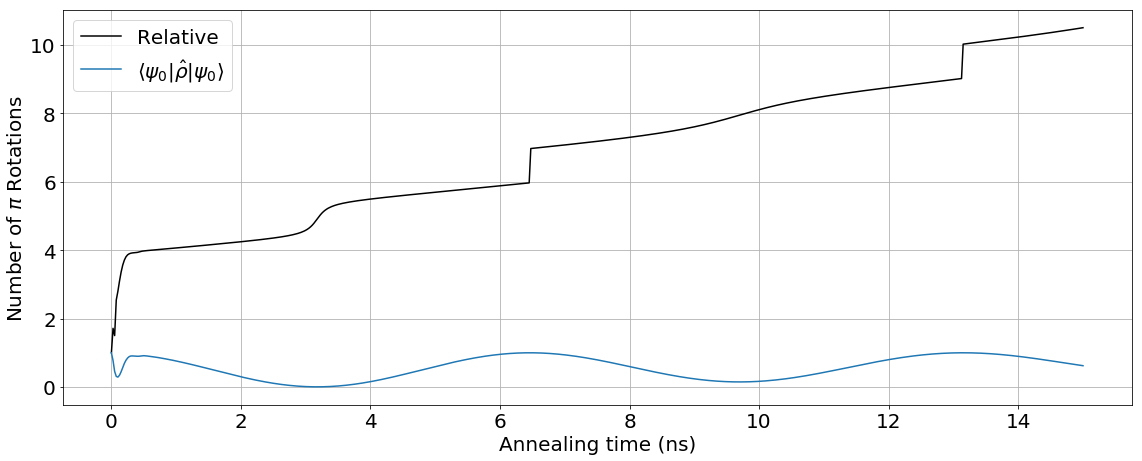

In [34]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

# Amplitude phases
#ax[0].plot(times_des/tf[min_list[3]], np.unwrap(alpha_p_des,discont=180),label="$\\arg{\\langle g | \\psi(t) \\rangle}$")
#ax[0].plot(times_des/tf[min_list[3]], np.unwrap(beta_p_des,discont=180),label="$\\arg{\\langle e | \\psi(t) \\rangle}$")
#ax.plot(tf, -tfrelphases/np.pi,"k-",label="Relative")
ax.plot(tf, -t0relphases/np.pi,"k-",label="Relative")
#ax.plot(tf, t0phases_b,"k-",label="Relative")
ax.plot(tf, p0_cm,label="$\\langle\\psi_0|\\hat{\\rho}|\\psi_0\\rangle$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Number of $\pi$ Rotations')
ax.legend(loc=2)
ax.grid()

There is some kind of problem here, not sure what is going on.

In [673]:
def writebin(obj,filename):
    fd = open(filename,"wb")
    pickle.dump(obj,fd)
    fd.close()

obj = [
    p0_cm,
    final_dms,
    final_states,
    p0_cmo,
    final_dmso
]

writebin(obj,"dynamics_sim_data.bin")

In [3]:
def readbin(filename):
    fd = open(filename,"rb")
    obj = pickle.load(fd)
    fd.close()
    return obj

p0_cm,final_dms,final_states,p0_cmo,final_dmso = readbin("dynamics_sim_data.bin")

In [62]:
#
#   CSFQ Hamiltonian with BO approximation and negligible inductance.
#
def Hcsfq_BO_nL_mod(phi_x,phi_z,Jc,Ca,Ajj,alpha,Csh,asy=0.0,Q=None,Dp=None,Dm=None):

    # Asymmetry factor and phase
    asy_f = np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
    asy_p = np.arctan(asy * np.tan(phi_x/2))
    
    # Total capacitance (F)
    Csigma = (0.5+alpha)*Ajj*Ca*1e-15 + Csh
    
    # Charging energy (GHz)
    Ec = 2*pc.e**2/(Csigma*2*np.pi*pc.hbar) * 1e-9
    
    # Josephson energy (GHz)
    Ej = Ajj*Jc*pc.phi0/(4*np.pi**2*pc.hbar) * 1e-15
    
    # Construct Hamiltonian
    H = 0.5*Ec*Q**2 - Ej*(Dp+Dm) + asy_f*0.5*alpha*Ej*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*Dp**2+np.exp(-1j*(phi_z-asy_p))*Dm**2)
    
    # Return relevant parts (convert to rGHz)
    return H*2*np.pi

# Time dependent operator prefactors
def coef1(t,p):
    return np.cos(phi_x_sig(t,p)/2)*np.exp(1j*(phi_z_sig(t,p)))
def coef2(t,p):
    return np.cos(phi_x_sig(t,p)/2)*np.exp(-1j*(phi_z_sig(t,p)))

# Range of annealing times
tf_min = 0.0
tf_max = 15.0
tf = np.linspace(tf_min,tf_max,601)

# Hamiltonian at t=0
tan = 1
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
asy=0.0
H0 = Hcsfq_BO_nL_mod(phi_x_sig(0,p),phi_z_sig(0,p),Jc,Ca,Ajj,alpha,Csh,asy=asy,Q=Q,Dp=Dp,Dm=Dm)

# Get the ground state at t=0 with eigenvalue E0
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

peak_list=scs.find_peaks(p0_cm)[0]
min_list=scs.find_peaks(1-np.array(p0_cm))[0]

In [35]:
# Get phase differences from kets
rel_phase_tan = np.array([(np.angle((psi0.dag()*s[0])[0][0][0])-np.angle((psi_i[1].dag()*s[0])[0][0][0]))-(np.angle((psi0.dag()*s[1])[0][0][0])-np.angle((psi_i[1].dag()*s[1])[0][0][0])) for s in final_states])/np.pi

tsphases_a = np.unwrap(np.array([np.angle((psi0.dag()*s[0])[0][0][0]) for s in final_states]))
tsphases_b = np.unwrap(np.array([np.angle((psi_i[1].dag()*s[0])[0][0][0]) for s in final_states]))

t0phases_a = np.unwrap(np.array([np.angle((psi0.dag()*s[1])[0][0][0]) for s in final_states]))
t0phases_b = np.unwrap(np.array([np.angle((psi_i[1].dag()*s[1])[0][0][0]) for s in final_states]))

t0relphases = t0phases_b - t0phases_a

tfphases_a = np.unwrap(t0phases_a) - np.unwrap(tsphases_a)
tfphases_b = np.unwrap(t0phases_b) - np.unwrap(tsphases_b)

tfrelphases = tfphases_b - tfphases_a



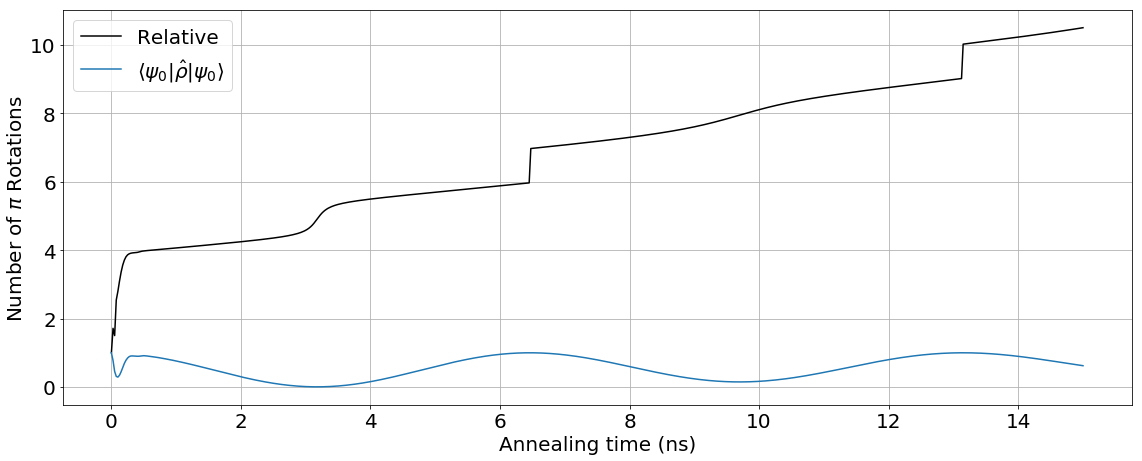

In [36]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

# Amplitude phases
#ax[0].plot(times_des/tf[min_list[3]], np.unwrap(alpha_p_des,discont=180),label="$\\arg{\\langle g | \\psi(t) \\rangle}$")
#ax[0].plot(times_des/tf[min_list[3]], np.unwrap(beta_p_des,discont=180),label="$\\arg{\\langle e | \\psi(t) \\rangle}$")
#ax.plot(tf, -tfrelphases/np.pi,"k-",label="Relative")
ax.plot(tf, -t0relphases/np.pi,"k-",label="Relative")
#ax.plot(tf, t0phases_b,"k-",label="Relative")
ax.plot(tf, p0_cm,label="$\\langle\\psi_0|\\hat{\\rho}|\\psi_0\\rangle$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Number of $\pi$ Rotations')
ax.legend(loc=2)
ax.grid()

In [82]:
arr = -t0relphases/np.pi
for i in range(len(arr)-1):
    if arr[i+1] - arr[i] > 1.0:
        print (i)

2
258
525


In [83]:
arr[0:2]

array([1.        , 1.71504967])

In [84]:
arr[259:] -= 1

In [85]:
arr[526:] -= 1

In [79]:
for i in range(len(arr)-1):
    if arr[i+1] - arr[i] < 0.0:
        print (i)

1


In [80]:
print (arr[0:4])
print (arr[1]-arr[2])
arr[2:] += (arr[1]-arr[2])/2

[1.         1.71504967 1.50325629 2.54299775]
0.21179338652114255


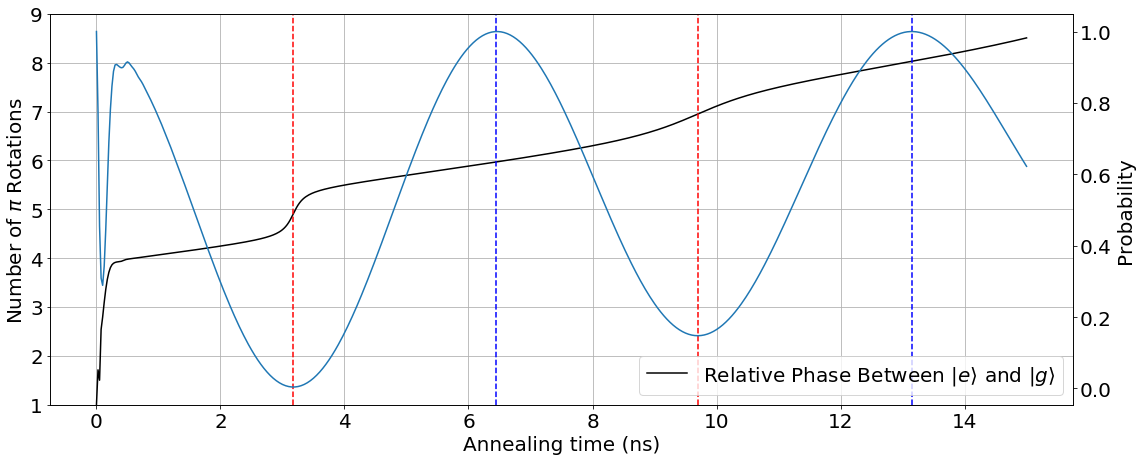

In [100]:
# Plot annealing schedule and oscillations of z expectation value
fig,ax = plt.subplots(1,1,constrained_layout=True,figsize=(40*0.393701,16*0.393701))

# Amplitude phases
#ax[0].plot(times_des/tf[min_list[3]], np.unwrap(alpha_p_des,discont=180),label="$\\arg{\\langle g | \\psi(t) \\rangle}$")
#ax[0].plot(times_des/tf[min_list[3]], np.unwrap(beta_p_des,discont=180),label="$\\arg{\\langle e | \\psi(t) \\rangle}$")
#ax.plot(tf, -tfrelphases/np.pi,"k-",label="Relative")
ax.plot(tf, arr,"k-",label="Relative Phase Between $|e\\rangle$ and $|g\\rangle$")
ax.plot([tf[min_list[2]],tf[min_list[2]]],[1,9],"r--")
ax.plot([tf[peak_list[2]],tf[peak_list[2]]],[1,9],"b--")
ax.plot([tf[min_list[3]],tf[min_list[3]]],[1,9],"r--")
ax.plot([tf[peak_list[3]],tf[peak_list[3]]],[1,9],"b--")
ax.set_ylim([1,9])
#ax.plot(tf, t0phases_b,"k-",label="Relative")
ax1 = ax.twinx()
ax1.plot(tf, p0_cm,label="$\\langle\\psi_0|\\hat{\\rho}|\\psi_0\\rangle$")
ax.set_xlabel('Annealing time (ns)')
ax.set_ylabel('Number of $\pi$ Rotations')
ax1.set_ylabel('Probability')
ax.legend(loc=4)
ax.grid()

In [63]:
tf[min_list[3]]

9.700000000000001